# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

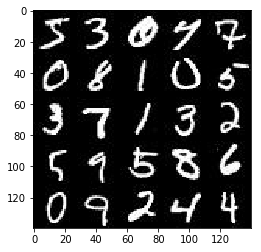

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

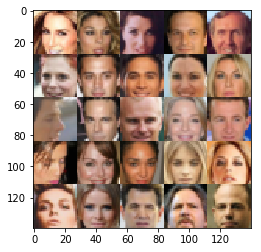

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [387]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Inspired by http://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        depth_1, depth_2, depth_3 = 256, 512, 1024
        conv_k = 4
        keep_prob = 0.5
        
        # Input layer is 28x28xDEPTH
        x = tf.layers.conv2d(images, depth_1, conv_k, (2, 2), padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.nn.dropout(x, keep_prob=keep_prob)
        # now 14x14xdepth_1
        
        x = tf.layers.conv2d(x, depth_2, conv_k, (2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x * alpha, x)
        x = tf.nn.dropout(x, keep_prob=keep_prob)
        # now 7x7xdepth_2
        
        x = tf.layers.conv2d(x, depth_3, conv_k, (2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x * alpha, x)
        x = tf.nn.dropout(x, keep_prob=keep_prob)
        # now 4x4xdepth_3
        
        x = tf.reshape(x, (-1, 4*4*depth_3))
        
        logits = tf.layers.dense(x, 1)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [386]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        alpha = 0.1
        depth_0, depth_1, depth_2, depth_3 = 512, 256, 128, 64
        conv_k = 4
        
        # leaky relu
        leaky_relu = lambda x: tf.maximum(x*alpha, x)
        
        # First fully connected layer
        first_dim = 7
        x = tf.layers.dense(z, depth_0*first_dim*first_dim)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        x = tf.reshape(x, (-1, first_dim, first_dim, depth_0))
        
        # convolutions
        conv_1 = tf.layers.conv2d_transpose(x, depth_1, conv_k, strides=2, padding='same') # 14x14x256
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_train)
        conv_1 = leaky_relu(conv_1)
        
        conv_2 = tf.layers.conv2d_transpose(conv_1, depth_2, conv_k, strides=2, padding='same') # 28x28x128
        conv_2 = tf.layers.batch_normalization(conv_2, training=is_train)
        conv_2 = leaky_relu(conv_2)
        
        conv_3 = tf.layers.conv2d(conv_2, depth_3, conv_k, strides=1, padding='same') # 28x28x128
        conv_3 = tf.layers.batch_normalization(conv_3, training=is_train)
        conv_3 = leaky_relu(conv_3)
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d(conv_3, out_channel_dim, 1, strides=1, padding='same')
        
        out = tf.tanh(logits, name='generated_img')
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [265]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [379]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [87]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [348]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build the model
    input_real, input_z, tf_learning_rate = model_inputs(28, 28, data_shape[-1], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])

    d_opt, g_opt = model_opt(d_loss, g_loss, tf_learning_rate, beta1)
    
    # Train the model
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Batch images are from -0.5 to 0.5, while tanh output is from -1 to 1, 
                # so we need to normalise
                batch_images = batch_images * 2

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, tf_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, tf_learning_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}, step {}...".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g),
                          "Total: {:.4f}".format(train_loss_d + train_loss_g)) 

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[-1], data_image_mode)

        tf.train.Saver().save(sess, './checkpoints/generator{}.ckpt'.format(data_image_mode))
        show_generator_output(sess, 25, input_z, data_shape[-1], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, step 10... Discriminator Loss: 0.4861... Generator Loss: 5.3566... Total: 5.8427
Epoch 1/2, step 20... Discriminator Loss: 0.5485... Generator Loss: 5.9273... Total: 6.4757
Epoch 1/2, step 30... Discriminator Loss: 0.5751... Generator Loss: 9.4509... Total: 10.0260
Epoch 1/2, step 40... Discriminator Loss: 2.2709... Generator Loss: 8.6843... Total: 10.9552
Epoch 1/2, step 50... Discriminator Loss: 0.4641... Generator Loss: 12.0756... Total: 12.5397
Epoch 1/2, step 60... Discriminator Loss: 0.9283... Generator Loss: 7.1368... Total: 8.0650
Epoch 1/2, step 70... Discriminator Loss: 0.6427... Generator Loss: 7.1587... Total: 7.8014
Epoch 1/2, step 80... Discriminator Loss: 0.7972... Generator Loss: 2.3314... Total: 3.1286
Epoch 1/2, step 90... Discriminator Loss: 1.0853... Generator Loss: 1.9493... Total: 3.0347
Epoch 1/2, step 100... Discriminator Loss: 1.1252... Generator Loss: 2.0206... Total: 3.1458


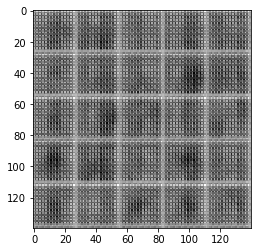

Epoch 1/2, step 110... Discriminator Loss: 2.5306... Generator Loss: 0.3560... Total: 2.8866
Epoch 1/2, step 120... Discriminator Loss: 1.7308... Generator Loss: 1.9529... Total: 3.6837
Epoch 1/2, step 130... Discriminator Loss: 1.7225... Generator Loss: 0.9648... Total: 2.6874
Epoch 1/2, step 140... Discriminator Loss: 1.9507... Generator Loss: 0.5173... Total: 2.4680
Epoch 1/2, step 150... Discriminator Loss: 1.7129... Generator Loss: 1.0675... Total: 2.7804
Epoch 1/2, step 160... Discriminator Loss: 2.0912... Generator Loss: 0.5321... Total: 2.6233
Epoch 1/2, step 170... Discriminator Loss: 1.9115... Generator Loss: 1.8511... Total: 3.7626
Epoch 1/2, step 180... Discriminator Loss: 1.6566... Generator Loss: 0.7632... Total: 2.4198
Epoch 1/2, step 190... Discriminator Loss: 1.4359... Generator Loss: 0.8422... Total: 2.2782
Epoch 1/2, step 200... Discriminator Loss: 1.5203... Generator Loss: 1.2995... Total: 2.8198


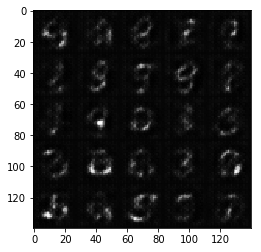

Epoch 1/2, step 210... Discriminator Loss: 1.4496... Generator Loss: 1.4956... Total: 2.9452
Epoch 1/2, step 220... Discriminator Loss: 1.7319... Generator Loss: 0.8601... Total: 2.5919
Epoch 1/2, step 230... Discriminator Loss: 1.4614... Generator Loss: 0.6794... Total: 2.1409
Epoch 1/2, step 240... Discriminator Loss: 1.6921... Generator Loss: 0.6098... Total: 2.3019
Epoch 1/2, step 250... Discriminator Loss: 1.3543... Generator Loss: 1.3670... Total: 2.7213
Epoch 1/2, step 260... Discriminator Loss: 1.2659... Generator Loss: 1.2902... Total: 2.5561
Epoch 1/2, step 270... Discriminator Loss: 1.3241... Generator Loss: 1.1273... Total: 2.4513
Epoch 1/2, step 280... Discriminator Loss: 1.6659... Generator Loss: 0.6854... Total: 2.3513
Epoch 1/2, step 290... Discriminator Loss: 1.5535... Generator Loss: 0.5755... Total: 2.1290
Epoch 1/2, step 300... Discriminator Loss: 1.2062... Generator Loss: 1.1203... Total: 2.3265


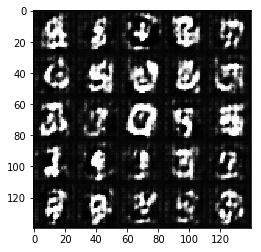

Epoch 1/2, step 310... Discriminator Loss: 1.1600... Generator Loss: 1.4599... Total: 2.6200
Epoch 1/2, step 320... Discriminator Loss: 1.3257... Generator Loss: 1.8306... Total: 3.1563
Epoch 1/2, step 330... Discriminator Loss: 1.0526... Generator Loss: 1.6139... Total: 2.6665
Epoch 1/2, step 340... Discriminator Loss: 1.2781... Generator Loss: 1.6936... Total: 2.9717
Epoch 1/2, step 350... Discriminator Loss: 1.0840... Generator Loss: 1.8575... Total: 2.9414
Epoch 1/2, step 360... Discriminator Loss: 1.1940... Generator Loss: 1.1002... Total: 2.2941
Epoch 1/2, step 370... Discriminator Loss: 1.7171... Generator Loss: 0.5572... Total: 2.2743
Epoch 1/2, step 380... Discriminator Loss: 1.5120... Generator Loss: 0.6926... Total: 2.2046
Epoch 1/2, step 390... Discriminator Loss: 1.9093... Generator Loss: 0.5104... Total: 2.4197
Epoch 1/2, step 400... Discriminator Loss: 2.1837... Generator Loss: 0.3640... Total: 2.5477


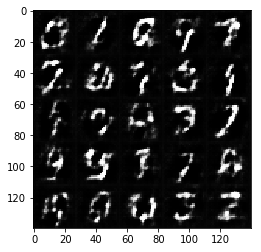

Epoch 1/2, step 410... Discriminator Loss: 1.2878... Generator Loss: 1.4319... Total: 2.7197
Epoch 1/2, step 420... Discriminator Loss: 1.2900... Generator Loss: 1.6332... Total: 2.9232
Epoch 1/2, step 430... Discriminator Loss: 1.4384... Generator Loss: 1.4083... Total: 2.8466
Epoch 1/2, step 440... Discriminator Loss: 1.2954... Generator Loss: 1.5457... Total: 2.8411
Epoch 1/2, step 450... Discriminator Loss: 1.5394... Generator Loss: 2.1106... Total: 3.6500
Epoch 1/2, step 460... Discriminator Loss: 1.2946... Generator Loss: 1.2830... Total: 2.5775
Epoch 1/2, step 470... Discriminator Loss: 2.2102... Generator Loss: 0.3083... Total: 2.5185
Epoch 1/2, step 480... Discriminator Loss: 1.6566... Generator Loss: 0.6396... Total: 2.2962
Epoch 1/2, step 490... Discriminator Loss: 1.3925... Generator Loss: 1.2600... Total: 2.6526
Epoch 1/2, step 500... Discriminator Loss: 1.3385... Generator Loss: 1.0755... Total: 2.4140


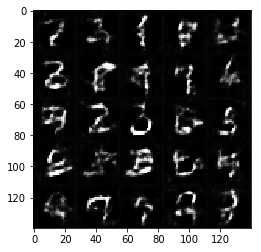

Epoch 1/2, step 510... Discriminator Loss: 1.6949... Generator Loss: 0.7404... Total: 2.4353
Epoch 1/2, step 520... Discriminator Loss: 1.2392... Generator Loss: 1.2091... Total: 2.4483
Epoch 1/2, step 530... Discriminator Loss: 1.5271... Generator Loss: 0.7488... Total: 2.2759
Epoch 1/2, step 540... Discriminator Loss: 1.2857... Generator Loss: 2.0650... Total: 3.3507
Epoch 1/2, step 550... Discriminator Loss: 1.3951... Generator Loss: 1.6061... Total: 3.0012
Epoch 1/2, step 560... Discriminator Loss: 1.2928... Generator Loss: 0.9389... Total: 2.2317
Epoch 1/2, step 570... Discriminator Loss: 1.5904... Generator Loss: 0.5655... Total: 2.1559
Epoch 1/2, step 580... Discriminator Loss: 1.2560... Generator Loss: 0.6129... Total: 1.8689
Epoch 1/2, step 590... Discriminator Loss: 1.8158... Generator Loss: 0.4623... Total: 2.2781
Epoch 1/2, step 600... Discriminator Loss: 1.4048... Generator Loss: 1.0057... Total: 2.4106


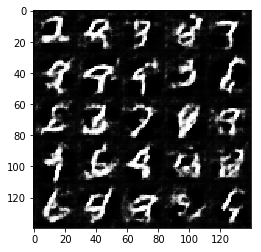

Epoch 1/2, step 610... Discriminator Loss: 1.3837... Generator Loss: 0.9770... Total: 2.3607
Epoch 1/2, step 620... Discriminator Loss: 1.4859... Generator Loss: 1.8523... Total: 3.3382
Epoch 1/2, step 630... Discriminator Loss: 1.4032... Generator Loss: 1.3642... Total: 2.7674
Epoch 1/2, step 640... Discriminator Loss: 1.2584... Generator Loss: 1.1587... Total: 2.4170
Epoch 1/2, step 650... Discriminator Loss: 1.3108... Generator Loss: 1.2663... Total: 2.5771
Epoch 1/2, step 660... Discriminator Loss: 1.2848... Generator Loss: 1.0454... Total: 2.3302
Epoch 1/2, step 670... Discriminator Loss: 1.4056... Generator Loss: 0.7429... Total: 2.1485
Epoch 1/2, step 680... Discriminator Loss: 1.5037... Generator Loss: 1.0289... Total: 2.5326
Epoch 1/2, step 690... Discriminator Loss: 1.1384... Generator Loss: 1.3183... Total: 2.4567
Epoch 1/2, step 700... Discriminator Loss: 1.5354... Generator Loss: 0.4691... Total: 2.0045


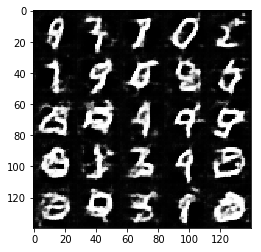

Epoch 1/2, step 710... Discriminator Loss: 1.5281... Generator Loss: 2.3875... Total: 3.9156
Epoch 1/2, step 720... Discriminator Loss: 1.3532... Generator Loss: 0.8548... Total: 2.2081
Epoch 1/2, step 730... Discriminator Loss: 1.2324... Generator Loss: 1.1991... Total: 2.4314
Epoch 1/2, step 740... Discriminator Loss: 1.3484... Generator Loss: 0.9857... Total: 2.3341
Epoch 1/2, step 750... Discriminator Loss: 1.5330... Generator Loss: 0.5843... Total: 2.1174
Epoch 1/2, step 760... Discriminator Loss: 1.1706... Generator Loss: 1.0144... Total: 2.1850
Epoch 1/2, step 770... Discriminator Loss: 1.5225... Generator Loss: 0.6939... Total: 2.2164
Epoch 1/2, step 780... Discriminator Loss: 1.2434... Generator Loss: 1.1399... Total: 2.3833
Epoch 1/2, step 790... Discriminator Loss: 1.2792... Generator Loss: 1.2759... Total: 2.5551
Epoch 1/2, step 800... Discriminator Loss: 1.5254... Generator Loss: 0.7153... Total: 2.2407


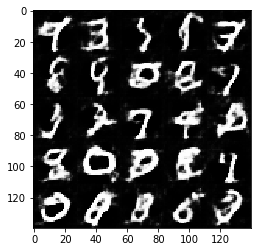

Epoch 1/2, step 810... Discriminator Loss: 1.2450... Generator Loss: 1.3674... Total: 2.6124
Epoch 1/2, step 820... Discriminator Loss: 1.1906... Generator Loss: 1.5691... Total: 2.7597
Epoch 1/2, step 830... Discriminator Loss: 1.2049... Generator Loss: 0.9584... Total: 2.1632
Epoch 1/2, step 840... Discriminator Loss: 1.0565... Generator Loss: 1.3076... Total: 2.3641
Epoch 1/2, step 850... Discriminator Loss: 1.2715... Generator Loss: 1.6633... Total: 2.9349
Epoch 1/2, step 860... Discriminator Loss: 1.9429... Generator Loss: 0.4583... Total: 2.4012
Epoch 1/2, step 870... Discriminator Loss: 1.7726... Generator Loss: 1.1348... Total: 2.9074
Epoch 1/2, step 880... Discriminator Loss: 1.2221... Generator Loss: 1.0390... Total: 2.2611
Epoch 1/2, step 890... Discriminator Loss: 1.3880... Generator Loss: 1.6499... Total: 3.0379
Epoch 1/2, step 900... Discriminator Loss: 1.3191... Generator Loss: 0.7847... Total: 2.1038


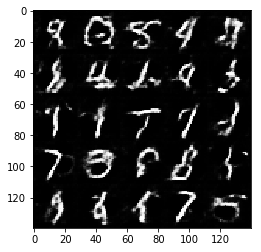

Epoch 1/2, step 910... Discriminator Loss: 1.3610... Generator Loss: 1.0759... Total: 2.4369
Epoch 1/2, step 920... Discriminator Loss: 1.3828... Generator Loss: 0.7640... Total: 2.1468
Epoch 1/2, step 930... Discriminator Loss: 1.3168... Generator Loss: 1.0051... Total: 2.3220
Epoch 2/2, step 940... Discriminator Loss: 1.2715... Generator Loss: 1.2001... Total: 2.4716
Epoch 2/2, step 950... Discriminator Loss: 1.3006... Generator Loss: 0.8851... Total: 2.1857
Epoch 2/2, step 960... Discriminator Loss: 1.2237... Generator Loss: 1.1295... Total: 2.3532
Epoch 2/2, step 970... Discriminator Loss: 1.4087... Generator Loss: 0.6713... Total: 2.0800
Epoch 2/2, step 980... Discriminator Loss: 1.4484... Generator Loss: 0.8504... Total: 2.2988
Epoch 2/2, step 990... Discriminator Loss: 1.3658... Generator Loss: 1.2857... Total: 2.6514
Epoch 2/2, step 1000... Discriminator Loss: 1.2947... Generator Loss: 0.9933... Total: 2.2880


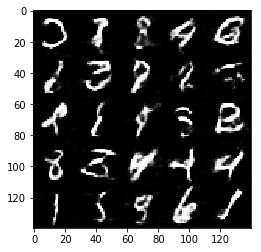

Epoch 2/2, step 1010... Discriminator Loss: 1.2830... Generator Loss: 0.9274... Total: 2.2103
Epoch 2/2, step 1020... Discriminator Loss: 1.1544... Generator Loss: 1.6393... Total: 2.7937
Epoch 2/2, step 1030... Discriminator Loss: 1.1720... Generator Loss: 1.1903... Total: 2.3622
Epoch 2/2, step 1040... Discriminator Loss: 1.3740... Generator Loss: 0.8426... Total: 2.2165
Epoch 2/2, step 1050... Discriminator Loss: 1.2842... Generator Loss: 1.5210... Total: 2.8052
Epoch 2/2, step 1060... Discriminator Loss: 1.3541... Generator Loss: 1.1229... Total: 2.4770
Epoch 2/2, step 1070... Discriminator Loss: 1.1837... Generator Loss: 1.3088... Total: 2.4926
Epoch 2/2, step 1080... Discriminator Loss: 1.3329... Generator Loss: 1.2266... Total: 2.5594
Epoch 2/2, step 1090... Discriminator Loss: 1.2780... Generator Loss: 1.2281... Total: 2.5061
Epoch 2/2, step 1100... Discriminator Loss: 1.3850... Generator Loss: 0.8163... Total: 2.2013


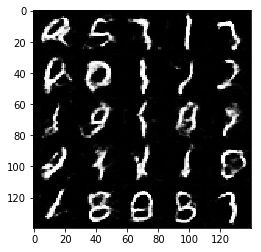

Epoch 2/2, step 1110... Discriminator Loss: 1.2142... Generator Loss: 1.9223... Total: 3.1365
Epoch 2/2, step 1120... Discriminator Loss: 1.0705... Generator Loss: 1.2217... Total: 2.2922
Epoch 2/2, step 1130... Discriminator Loss: 1.3459... Generator Loss: 1.1478... Total: 2.4936
Epoch 2/2, step 1140... Discriminator Loss: 1.2702... Generator Loss: 1.0309... Total: 2.3010
Epoch 2/2, step 1150... Discriminator Loss: 1.3877... Generator Loss: 0.7411... Total: 2.1288
Epoch 2/2, step 1160... Discriminator Loss: 1.3666... Generator Loss: 1.1343... Total: 2.5010
Epoch 2/2, step 1170... Discriminator Loss: 1.2565... Generator Loss: 0.9711... Total: 2.2276
Epoch 2/2, step 1180... Discriminator Loss: 1.5323... Generator Loss: 0.5959... Total: 2.1282
Epoch 2/2, step 1190... Discriminator Loss: 1.2113... Generator Loss: 0.9740... Total: 2.1854
Epoch 2/2, step 1200... Discriminator Loss: 1.2852... Generator Loss: 0.8922... Total: 2.1773


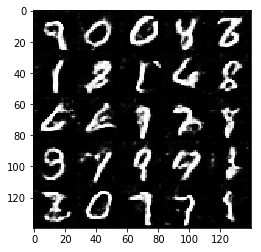

Epoch 2/2, step 1210... Discriminator Loss: 1.1914... Generator Loss: 1.0401... Total: 2.2315
Epoch 2/2, step 1220... Discriminator Loss: 1.2875... Generator Loss: 1.3830... Total: 2.6705
Epoch 2/2, step 1230... Discriminator Loss: 1.2663... Generator Loss: 0.9142... Total: 2.1805
Epoch 2/2, step 1240... Discriminator Loss: 1.3166... Generator Loss: 0.7638... Total: 2.0803
Epoch 2/2, step 1250... Discriminator Loss: 1.3579... Generator Loss: 0.9905... Total: 2.3484
Epoch 2/2, step 1260... Discriminator Loss: 1.2723... Generator Loss: 1.1668... Total: 2.4391
Epoch 2/2, step 1270... Discriminator Loss: 1.4366... Generator Loss: 0.7425... Total: 2.1792
Epoch 2/2, step 1280... Discriminator Loss: 1.3251... Generator Loss: 0.8516... Total: 2.1767
Epoch 2/2, step 1290... Discriminator Loss: 1.3147... Generator Loss: 1.6347... Total: 2.9494
Epoch 2/2, step 1300... Discriminator Loss: 1.2799... Generator Loss: 1.1571... Total: 2.4371


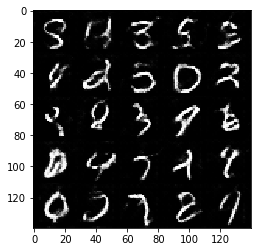

Epoch 2/2, step 1310... Discriminator Loss: 1.4483... Generator Loss: 0.8491... Total: 2.2974
Epoch 2/2, step 1320... Discriminator Loss: 1.6634... Generator Loss: 1.1783... Total: 2.8417
Epoch 2/2, step 1330... Discriminator Loss: 1.4000... Generator Loss: 1.0279... Total: 2.4280
Epoch 2/2, step 1340... Discriminator Loss: 1.2168... Generator Loss: 1.1788... Total: 2.3956
Epoch 2/2, step 1350... Discriminator Loss: 1.5045... Generator Loss: 0.5694... Total: 2.0738
Epoch 2/2, step 1360... Discriminator Loss: 1.5277... Generator Loss: 0.6301... Total: 2.1579
Epoch 2/2, step 1370... Discriminator Loss: 1.3632... Generator Loss: 1.3524... Total: 2.7156
Epoch 2/2, step 1380... Discriminator Loss: 1.2415... Generator Loss: 1.0482... Total: 2.2897
Epoch 2/2, step 1390... Discriminator Loss: 1.4410... Generator Loss: 0.7283... Total: 2.1693
Epoch 2/2, step 1400... Discriminator Loss: 1.3704... Generator Loss: 0.6596... Total: 2.0299


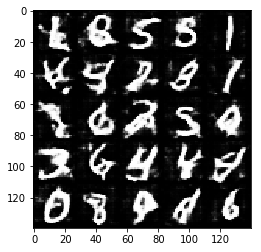

Epoch 2/2, step 1410... Discriminator Loss: 1.4669... Generator Loss: 0.9437... Total: 2.4105
Epoch 2/2, step 1420... Discriminator Loss: 1.5890... Generator Loss: 0.8984... Total: 2.4874
Epoch 2/2, step 1430... Discriminator Loss: 1.4861... Generator Loss: 1.5061... Total: 2.9921
Epoch 2/2, step 1440... Discriminator Loss: 1.2784... Generator Loss: 0.7996... Total: 2.0779
Epoch 2/2, step 1450... Discriminator Loss: 1.3839... Generator Loss: 1.2974... Total: 2.6812
Epoch 2/2, step 1460... Discriminator Loss: 1.2801... Generator Loss: 0.7732... Total: 2.0533
Epoch 2/2, step 1470... Discriminator Loss: 1.3979... Generator Loss: 0.9082... Total: 2.3061
Epoch 2/2, step 1480... Discriminator Loss: 1.2765... Generator Loss: 1.0569... Total: 2.3334
Epoch 2/2, step 1490... Discriminator Loss: 1.4898... Generator Loss: 0.6834... Total: 2.1732
Epoch 2/2, step 1500... Discriminator Loss: 1.2538... Generator Loss: 1.0923... Total: 2.3462


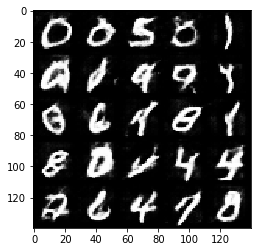

Epoch 2/2, step 1510... Discriminator Loss: 1.4075... Generator Loss: 0.6832... Total: 2.0907
Epoch 2/2, step 1520... Discriminator Loss: 1.3829... Generator Loss: 1.4907... Total: 2.8736
Epoch 2/2, step 1530... Discriminator Loss: 1.2413... Generator Loss: 0.9822... Total: 2.2235
Epoch 2/2, step 1540... Discriminator Loss: 1.2041... Generator Loss: 1.1674... Total: 2.3715
Epoch 2/2, step 1550... Discriminator Loss: 1.2125... Generator Loss: 1.0167... Total: 2.2292
Epoch 2/2, step 1560... Discriminator Loss: 1.4774... Generator Loss: 0.8107... Total: 2.2881
Epoch 2/2, step 1570... Discriminator Loss: 1.4139... Generator Loss: 1.0575... Total: 2.4715
Epoch 2/2, step 1580... Discriminator Loss: 1.2953... Generator Loss: 0.8535... Total: 2.1488
Epoch 2/2, step 1590... Discriminator Loss: 1.4859... Generator Loss: 0.8974... Total: 2.3833
Epoch 2/2, step 1600... Discriminator Loss: 1.3520... Generator Loss: 0.9443... Total: 2.2963


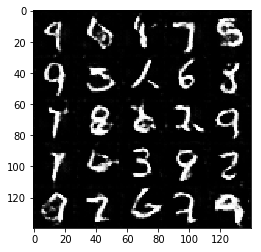

Epoch 2/2, step 1610... Discriminator Loss: 1.3013... Generator Loss: 0.9942... Total: 2.2955
Epoch 2/2, step 1620... Discriminator Loss: 1.2199... Generator Loss: 1.0767... Total: 2.2966
Epoch 2/2, step 1630... Discriminator Loss: 1.4902... Generator Loss: 0.6771... Total: 2.1673
Epoch 2/2, step 1640... Discriminator Loss: 1.2503... Generator Loss: 1.1132... Total: 2.3635
Epoch 2/2, step 1650... Discriminator Loss: 1.2750... Generator Loss: 1.1295... Total: 2.4045
Epoch 2/2, step 1660... Discriminator Loss: 1.3044... Generator Loss: 0.9237... Total: 2.2280
Epoch 2/2, step 1670... Discriminator Loss: 1.2358... Generator Loss: 0.8787... Total: 2.1145
Epoch 2/2, step 1680... Discriminator Loss: 1.1758... Generator Loss: 1.1488... Total: 2.3246
Epoch 2/2, step 1690... Discriminator Loss: 1.3458... Generator Loss: 0.7050... Total: 2.0508
Epoch 2/2, step 1700... Discriminator Loss: 1.5621... Generator Loss: 0.4894... Total: 2.0516


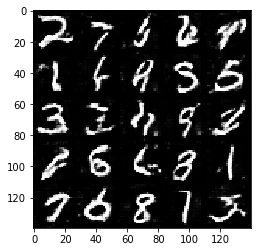

Epoch 2/2, step 1710... Discriminator Loss: 1.2451... Generator Loss: 0.9543... Total: 2.1994
Epoch 2/2, step 1720... Discriminator Loss: 1.4387... Generator Loss: 1.2926... Total: 2.7312
Epoch 2/2, step 1730... Discriminator Loss: 1.3155... Generator Loss: 1.1884... Total: 2.5039
Epoch 2/2, step 1740... Discriminator Loss: 1.4784... Generator Loss: 0.7830... Total: 2.2614
Epoch 2/2, step 1750... Discriminator Loss: 1.3716... Generator Loss: 0.9166... Total: 2.2881
Epoch 2/2, step 1760... Discriminator Loss: 1.2957... Generator Loss: 1.0303... Total: 2.3260
Epoch 2/2, step 1770... Discriminator Loss: 1.2627... Generator Loss: 0.8797... Total: 2.1423
Epoch 2/2, step 1780... Discriminator Loss: 1.3431... Generator Loss: 0.6067... Total: 1.9498
Epoch 2/2, step 1790... Discriminator Loss: 1.1189... Generator Loss: 0.9709... Total: 2.0899
Epoch 2/2, step 1800... Discriminator Loss: 1.4419... Generator Loss: 1.0393... Total: 2.4813


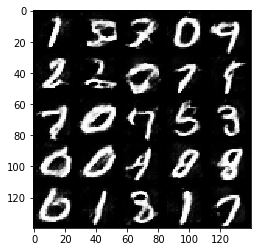

Epoch 2/2, step 1810... Discriminator Loss: 1.3314... Generator Loss: 1.3441... Total: 2.6755
Epoch 2/2, step 1820... Discriminator Loss: 1.3024... Generator Loss: 1.2926... Total: 2.5950
Epoch 2/2, step 1830... Discriminator Loss: 1.4510... Generator Loss: 0.7139... Total: 2.1650
Epoch 2/2, step 1840... Discriminator Loss: 1.3234... Generator Loss: 1.2118... Total: 2.5353
Epoch 2/2, step 1850... Discriminator Loss: 1.3630... Generator Loss: 1.0917... Total: 2.4546
Epoch 2/2, step 1860... Discriminator Loss: 1.2478... Generator Loss: 1.0518... Total: 2.2996
Epoch 2/2, step 1870... Discriminator Loss: 1.3106... Generator Loss: 1.0859... Total: 2.3966


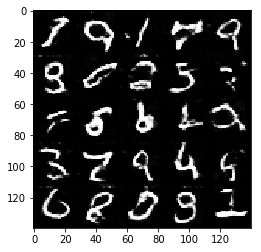

In [384]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3, step 10... Discriminator Loss: 0.6345... Generator Loss: 4.6590... Total: 5.2935
Epoch 1/3, step 20... Discriminator Loss: 0.6719... Generator Loss: 7.9908... Total: 8.6627
Epoch 1/3, step 30... Discriminator Loss: 0.4611... Generator Loss: 7.5093... Total: 7.9703
Epoch 1/3, step 40... Discriminator Loss: 0.5303... Generator Loss: 6.8912... Total: 7.4216
Epoch 1/3, step 50... Discriminator Loss: 0.5404... Generator Loss: 4.5566... Total: 5.0970
Epoch 1/3, step 60... Discriminator Loss: 0.5686... Generator Loss: 5.7893... Total: 6.3579
Epoch 1/3, step 70... Discriminator Loss: 0.4455... Generator Loss: 10.4688... Total: 10.9143
Epoch 1/3, step 80... Discriminator Loss: 0.4063... Generator Loss: 5.8880... Total: 6.2943
Epoch 1/3, step 90... Discriminator Loss: 0.3979... Generator Loss: 6.3905... Total: 6.7884
Epoch 1/3, step 100... Discriminator Loss: 0.4008... Generator Loss: 8.6558... Total: 9.0566


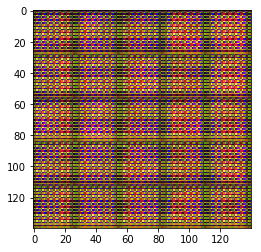

Epoch 1/3, step 110... Discriminator Loss: 0.5946... Generator Loss: 2.6208... Total: 3.2154
Epoch 1/3, step 120... Discriminator Loss: 0.7685... Generator Loss: 4.6301... Total: 5.3986
Epoch 1/3, step 130... Discriminator Loss: 0.6712... Generator Loss: 3.9072... Total: 4.5784
Epoch 1/3, step 140... Discriminator Loss: 1.5086... Generator Loss: 1.2394... Total: 2.7480
Epoch 1/3, step 150... Discriminator Loss: 4.9535... Generator Loss: 0.0774... Total: 5.0308
Epoch 1/3, step 160... Discriminator Loss: 1.2548... Generator Loss: 1.7968... Total: 3.0516
Epoch 1/3, step 170... Discriminator Loss: 1.7574... Generator Loss: 4.4639... Total: 6.2213
Epoch 1/3, step 180... Discriminator Loss: 1.4727... Generator Loss: 1.9642... Total: 3.4369
Epoch 1/3, step 190... Discriminator Loss: 1.7183... Generator Loss: 2.8281... Total: 4.5464
Epoch 1/3, step 200... Discriminator Loss: 1.4163... Generator Loss: 1.2931... Total: 2.7094


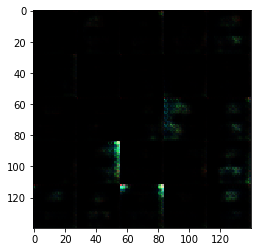

Epoch 1/3, step 210... Discriminator Loss: 1.1933... Generator Loss: 1.2799... Total: 2.4732
Epoch 1/3, step 220... Discriminator Loss: 1.3778... Generator Loss: 0.6826... Total: 2.0604
Epoch 1/3, step 230... Discriminator Loss: 1.0969... Generator Loss: 2.2698... Total: 3.3667
Epoch 1/3, step 240... Discriminator Loss: 1.4160... Generator Loss: 0.8729... Total: 2.2889
Epoch 1/3, step 250... Discriminator Loss: 1.4820... Generator Loss: 0.7982... Total: 2.2802
Epoch 1/3, step 260... Discriminator Loss: 1.2204... Generator Loss: 1.1943... Total: 2.4147
Epoch 1/3, step 270... Discriminator Loss: 1.5233... Generator Loss: 0.9313... Total: 2.4546
Epoch 1/3, step 280... Discriminator Loss: 1.5883... Generator Loss: 0.9003... Total: 2.4885
Epoch 1/3, step 290... Discriminator Loss: 1.3318... Generator Loss: 0.9929... Total: 2.3247
Epoch 1/3, step 300... Discriminator Loss: 1.5266... Generator Loss: 1.0042... Total: 2.5308


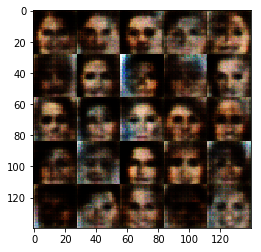

Epoch 1/3, step 310... Discriminator Loss: 1.4688... Generator Loss: 1.2471... Total: 2.7159
Epoch 1/3, step 320... Discriminator Loss: 0.7546... Generator Loss: 2.4857... Total: 3.2403
Epoch 1/3, step 330... Discriminator Loss: 2.2896... Generator Loss: 0.4806... Total: 2.7702
Epoch 1/3, step 340... Discriminator Loss: 1.2093... Generator Loss: 0.9935... Total: 2.2029
Epoch 1/3, step 350... Discriminator Loss: 1.1062... Generator Loss: 1.7592... Total: 2.8653
Epoch 1/3, step 360... Discriminator Loss: 1.9374... Generator Loss: 0.3674... Total: 2.3048
Epoch 1/3, step 370... Discriminator Loss: 1.5766... Generator Loss: 0.9560... Total: 2.5327
Epoch 1/3, step 380... Discriminator Loss: 1.3996... Generator Loss: 1.0906... Total: 2.4902
Epoch 1/3, step 390... Discriminator Loss: 1.4659... Generator Loss: 0.9131... Total: 2.3790
Epoch 1/3, step 400... Discriminator Loss: 1.3733... Generator Loss: 0.8477... Total: 2.2209


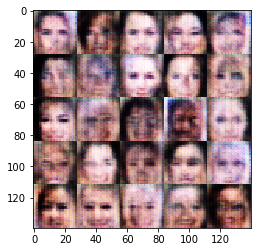

Epoch 1/3, step 410... Discriminator Loss: 1.1681... Generator Loss: 0.9948... Total: 2.1628
Epoch 1/3, step 420... Discriminator Loss: 1.2368... Generator Loss: 1.2925... Total: 2.5293
Epoch 1/3, step 430... Discriminator Loss: 1.3092... Generator Loss: 1.7875... Total: 3.0967
Epoch 1/3, step 440... Discriminator Loss: 1.8232... Generator Loss: 0.4280... Total: 2.2513
Epoch 1/3, step 450... Discriminator Loss: 1.2999... Generator Loss: 1.8108... Total: 3.1107
Epoch 1/3, step 460... Discriminator Loss: 1.2637... Generator Loss: 0.7873... Total: 2.0510
Epoch 1/3, step 470... Discriminator Loss: 1.4152... Generator Loss: 1.1766... Total: 2.5918
Epoch 1/3, step 480... Discriminator Loss: 1.7283... Generator Loss: 1.0393... Total: 2.7676
Epoch 1/3, step 490... Discriminator Loss: 1.2770... Generator Loss: 0.9287... Total: 2.2056
Epoch 1/3, step 500... Discriminator Loss: 1.4936... Generator Loss: 0.8271... Total: 2.3207


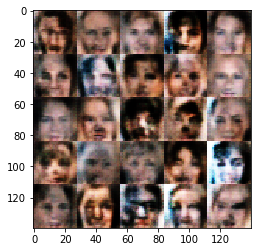

Epoch 1/3, step 510... Discriminator Loss: 1.6240... Generator Loss: 0.6482... Total: 2.2722
Epoch 1/3, step 520... Discriminator Loss: 1.3402... Generator Loss: 1.0235... Total: 2.3637
Epoch 1/3, step 530... Discriminator Loss: 1.3404... Generator Loss: 0.8221... Total: 2.1626
Epoch 1/3, step 540... Discriminator Loss: 1.6327... Generator Loss: 0.7472... Total: 2.3799
Epoch 1/3, step 550... Discriminator Loss: 1.4502... Generator Loss: 0.7891... Total: 2.2393
Epoch 1/3, step 560... Discriminator Loss: 1.4248... Generator Loss: 0.9745... Total: 2.3992
Epoch 1/3, step 570... Discriminator Loss: 1.5309... Generator Loss: 0.6512... Total: 2.1821
Epoch 1/3, step 580... Discriminator Loss: 1.4732... Generator Loss: 0.8184... Total: 2.2917
Epoch 1/3, step 590... Discriminator Loss: 1.4523... Generator Loss: 0.9163... Total: 2.3685
Epoch 1/3, step 600... Discriminator Loss: 1.2393... Generator Loss: 0.9948... Total: 2.2340


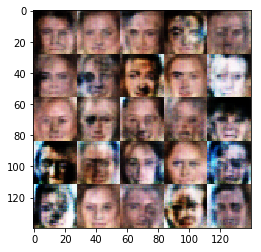

Epoch 1/3, step 610... Discriminator Loss: 1.4863... Generator Loss: 0.6163... Total: 2.1026
Epoch 1/3, step 620... Discriminator Loss: 1.6767... Generator Loss: 0.5838... Total: 2.2605
Epoch 1/3, step 630... Discriminator Loss: 1.4752... Generator Loss: 1.0716... Total: 2.5468
Epoch 1/3, step 640... Discriminator Loss: 1.5649... Generator Loss: 0.9225... Total: 2.4874
Epoch 1/3, step 650... Discriminator Loss: 1.4980... Generator Loss: 0.8172... Total: 2.3152
Epoch 1/3, step 660... Discriminator Loss: 1.5948... Generator Loss: 0.7615... Total: 2.3563
Epoch 1/3, step 670... Discriminator Loss: 1.4266... Generator Loss: 1.1082... Total: 2.5347
Epoch 1/3, step 680... Discriminator Loss: 1.5610... Generator Loss: 0.8856... Total: 2.4465
Epoch 1/3, step 690... Discriminator Loss: 1.4459... Generator Loss: 0.8028... Total: 2.2488
Epoch 1/3, step 700... Discriminator Loss: 1.5745... Generator Loss: 0.7658... Total: 2.3403


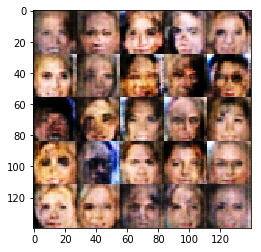

Epoch 1/3, step 710... Discriminator Loss: 1.4951... Generator Loss: 1.0594... Total: 2.5545
Epoch 1/3, step 720... Discriminator Loss: 1.5047... Generator Loss: 0.9066... Total: 2.4114
Epoch 1/3, step 730... Discriminator Loss: 1.4558... Generator Loss: 0.7871... Total: 2.2429
Epoch 1/3, step 740... Discriminator Loss: 1.4881... Generator Loss: 0.8869... Total: 2.3751
Epoch 1/3, step 750... Discriminator Loss: 1.4078... Generator Loss: 1.0517... Total: 2.4595
Epoch 1/3, step 760... Discriminator Loss: 1.3627... Generator Loss: 0.9872... Total: 2.3498
Epoch 1/3, step 770... Discriminator Loss: 1.4131... Generator Loss: 0.9404... Total: 2.3535
Epoch 1/3, step 780... Discriminator Loss: 1.3937... Generator Loss: 0.7286... Total: 2.1223
Epoch 1/3, step 790... Discriminator Loss: 1.4080... Generator Loss: 0.8920... Total: 2.3000
Epoch 1/3, step 800... Discriminator Loss: 1.5229... Generator Loss: 0.6856... Total: 2.2086


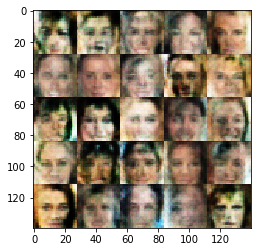

Epoch 1/3, step 810... Discriminator Loss: 1.4875... Generator Loss: 0.7714... Total: 2.2589
Epoch 1/3, step 820... Discriminator Loss: 1.4909... Generator Loss: 0.8136... Total: 2.3045
Epoch 1/3, step 830... Discriminator Loss: 1.4068... Generator Loss: 1.0352... Total: 2.4420
Epoch 1/3, step 840... Discriminator Loss: 1.4075... Generator Loss: 0.8146... Total: 2.2221
Epoch 1/3, step 850... Discriminator Loss: 1.3827... Generator Loss: 0.8597... Total: 2.2424
Epoch 1/3, step 860... Discriminator Loss: 1.6131... Generator Loss: 0.8309... Total: 2.4440
Epoch 1/3, step 870... Discriminator Loss: 1.3014... Generator Loss: 0.8304... Total: 2.1318
Epoch 1/3, step 880... Discriminator Loss: 1.4250... Generator Loss: 0.7420... Total: 2.1669
Epoch 1/3, step 890... Discriminator Loss: 1.5866... Generator Loss: 0.7848... Total: 2.3714
Epoch 1/3, step 900... Discriminator Loss: 1.4135... Generator Loss: 0.8553... Total: 2.2688


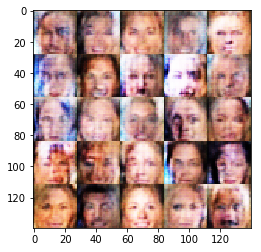

Epoch 1/3, step 910... Discriminator Loss: 1.5006... Generator Loss: 0.8058... Total: 2.3064
Epoch 1/3, step 920... Discriminator Loss: 1.5063... Generator Loss: 0.7495... Total: 2.2557
Epoch 1/3, step 930... Discriminator Loss: 1.4514... Generator Loss: 0.7677... Total: 2.2190
Epoch 1/3, step 940... Discriminator Loss: 1.5287... Generator Loss: 0.9537... Total: 2.4823
Epoch 1/3, step 950... Discriminator Loss: 1.4492... Generator Loss: 0.9909... Total: 2.4401
Epoch 1/3, step 960... Discriminator Loss: 1.5716... Generator Loss: 0.8264... Total: 2.3981
Epoch 1/3, step 970... Discriminator Loss: 1.6296... Generator Loss: 0.8591... Total: 2.4887
Epoch 1/3, step 980... Discriminator Loss: 1.3618... Generator Loss: 0.7852... Total: 2.1470
Epoch 1/3, step 990... Discriminator Loss: 1.4921... Generator Loss: 0.9321... Total: 2.4242
Epoch 1/3, step 1000... Discriminator Loss: 1.4382... Generator Loss: 1.3726... Total: 2.8108


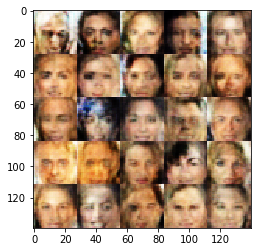

Epoch 1/3, step 1010... Discriminator Loss: 1.4544... Generator Loss: 0.7849... Total: 2.2393
Epoch 1/3, step 1020... Discriminator Loss: 1.4239... Generator Loss: 0.8896... Total: 2.3135
Epoch 1/3, step 1030... Discriminator Loss: 1.5069... Generator Loss: 0.9340... Total: 2.4410
Epoch 1/3, step 1040... Discriminator Loss: 1.3601... Generator Loss: 0.8246... Total: 2.1847
Epoch 1/3, step 1050... Discriminator Loss: 1.4778... Generator Loss: 0.8107... Total: 2.2885
Epoch 1/3, step 1060... Discriminator Loss: 1.4825... Generator Loss: 0.8165... Total: 2.2990
Epoch 1/3, step 1070... Discriminator Loss: 1.5663... Generator Loss: 0.9882... Total: 2.5545
Epoch 1/3, step 1080... Discriminator Loss: 1.3451... Generator Loss: 1.1187... Total: 2.4639
Epoch 1/3, step 1090... Discriminator Loss: 1.4712... Generator Loss: 0.8255... Total: 2.2967
Epoch 1/3, step 1100... Discriminator Loss: 1.6040... Generator Loss: 0.8495... Total: 2.4535


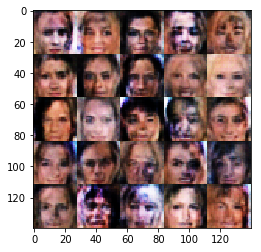

Epoch 1/3, step 1110... Discriminator Loss: 1.4539... Generator Loss: 0.8301... Total: 2.2840
Epoch 1/3, step 1120... Discriminator Loss: 1.4881... Generator Loss: 0.7164... Total: 2.2045
Epoch 1/3, step 1130... Discriminator Loss: 1.5200... Generator Loss: 0.9116... Total: 2.4315
Epoch 1/3, step 1140... Discriminator Loss: 1.3767... Generator Loss: 0.8502... Total: 2.2269
Epoch 1/3, step 1150... Discriminator Loss: 1.3530... Generator Loss: 0.8861... Total: 2.2391
Epoch 1/3, step 1160... Discriminator Loss: 1.4771... Generator Loss: 0.9569... Total: 2.4340
Epoch 1/3, step 1170... Discriminator Loss: 1.3911... Generator Loss: 0.8439... Total: 2.2350
Epoch 1/3, step 1180... Discriminator Loss: 1.3917... Generator Loss: 0.8334... Total: 2.2250
Epoch 1/3, step 1190... Discriminator Loss: 1.3752... Generator Loss: 0.8556... Total: 2.2308
Epoch 1/3, step 1200... Discriminator Loss: 1.3248... Generator Loss: 0.9364... Total: 2.2613


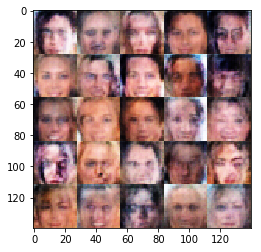

Epoch 1/3, step 1210... Discriminator Loss: 1.5338... Generator Loss: 0.8942... Total: 2.4280
Epoch 1/3, step 1220... Discriminator Loss: 1.4766... Generator Loss: 0.8939... Total: 2.3705
Epoch 1/3, step 1230... Discriminator Loss: 1.4557... Generator Loss: 0.7616... Total: 2.2173
Epoch 1/3, step 1240... Discriminator Loss: 1.5132... Generator Loss: 0.8046... Total: 2.3179
Epoch 1/3, step 1250... Discriminator Loss: 1.4375... Generator Loss: 0.8802... Total: 2.3177
Epoch 1/3, step 1260... Discriminator Loss: 1.5450... Generator Loss: 0.7203... Total: 2.2652
Epoch 1/3, step 1270... Discriminator Loss: 1.4737... Generator Loss: 1.0386... Total: 2.5124
Epoch 1/3, step 1280... Discriminator Loss: 1.4760... Generator Loss: 0.7772... Total: 2.2532
Epoch 1/3, step 1290... Discriminator Loss: 1.4384... Generator Loss: 0.9259... Total: 2.3642
Epoch 1/3, step 1300... Discriminator Loss: 1.5368... Generator Loss: 0.8633... Total: 2.4001


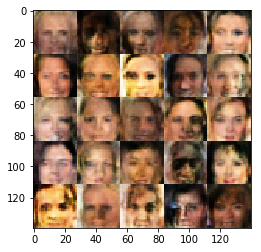

Epoch 1/3, step 1310... Discriminator Loss: 1.4398... Generator Loss: 0.7757... Total: 2.2155
Epoch 1/3, step 1320... Discriminator Loss: 1.4488... Generator Loss: 0.8416... Total: 2.2904
Epoch 1/3, step 1330... Discriminator Loss: 1.3506... Generator Loss: 0.8649... Total: 2.2155
Epoch 1/3, step 1340... Discriminator Loss: 1.3678... Generator Loss: 0.8194... Total: 2.1872
Epoch 1/3, step 1350... Discriminator Loss: 1.3520... Generator Loss: 0.9078... Total: 2.2599
Epoch 1/3, step 1360... Discriminator Loss: 1.4792... Generator Loss: 0.9416... Total: 2.4208
Epoch 1/3, step 1370... Discriminator Loss: 1.3992... Generator Loss: 0.9096... Total: 2.3089
Epoch 1/3, step 1380... Discriminator Loss: 1.4603... Generator Loss: 0.7304... Total: 2.1907
Epoch 1/3, step 1390... Discriminator Loss: 1.3851... Generator Loss: 0.8887... Total: 2.2739
Epoch 1/3, step 1400... Discriminator Loss: 1.4496... Generator Loss: 0.8554... Total: 2.3050


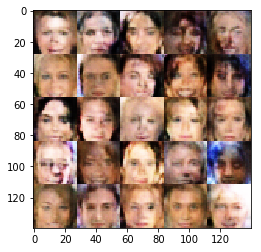

Epoch 1/3, step 1410... Discriminator Loss: 1.4934... Generator Loss: 0.7936... Total: 2.2870
Epoch 1/3, step 1420... Discriminator Loss: 1.4453... Generator Loss: 0.7959... Total: 2.2412
Epoch 1/3, step 1430... Discriminator Loss: 1.3640... Generator Loss: 0.7247... Total: 2.0887
Epoch 1/3, step 1440... Discriminator Loss: 1.4161... Generator Loss: 0.8696... Total: 2.2857
Epoch 1/3, step 1450... Discriminator Loss: 1.2918... Generator Loss: 0.8878... Total: 2.1796
Epoch 1/3, step 1460... Discriminator Loss: 1.4205... Generator Loss: 1.0350... Total: 2.4555
Epoch 1/3, step 1470... Discriminator Loss: 1.4730... Generator Loss: 0.8667... Total: 2.3397
Epoch 1/3, step 1480... Discriminator Loss: 1.4175... Generator Loss: 0.8307... Total: 2.2482
Epoch 1/3, step 1490... Discriminator Loss: 1.4899... Generator Loss: 0.7347... Total: 2.2246
Epoch 1/3, step 1500... Discriminator Loss: 1.3843... Generator Loss: 0.7596... Total: 2.1439


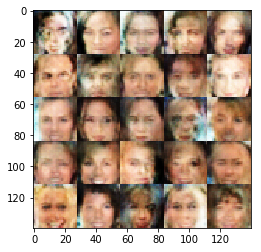

Epoch 1/3, step 1510... Discriminator Loss: 1.4788... Generator Loss: 1.0421... Total: 2.5209
Epoch 1/3, step 1520... Discriminator Loss: 1.5855... Generator Loss: 0.9664... Total: 2.5519
Epoch 1/3, step 1530... Discriminator Loss: 1.3325... Generator Loss: 0.7832... Total: 2.1157
Epoch 1/3, step 1540... Discriminator Loss: 1.2922... Generator Loss: 1.0410... Total: 2.3333
Epoch 1/3, step 1550... Discriminator Loss: 1.4770... Generator Loss: 0.9323... Total: 2.4093
Epoch 1/3, step 1560... Discriminator Loss: 1.4151... Generator Loss: 0.8071... Total: 2.2223
Epoch 1/3, step 1570... Discriminator Loss: 1.4361... Generator Loss: 0.9322... Total: 2.3683
Epoch 1/3, step 1580... Discriminator Loss: 1.3434... Generator Loss: 0.6951... Total: 2.0385
Epoch 1/3, step 1590... Discriminator Loss: 1.4122... Generator Loss: 0.6709... Total: 2.0831
Epoch 1/3, step 1600... Discriminator Loss: 1.4015... Generator Loss: 0.8811... Total: 2.2826


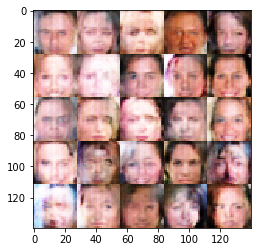

Epoch 1/3, step 1610... Discriminator Loss: 1.6099... Generator Loss: 1.2866... Total: 2.8965
Epoch 1/3, step 1620... Discriminator Loss: 1.3879... Generator Loss: 0.6505... Total: 2.0384
Epoch 1/3, step 1630... Discriminator Loss: 1.4222... Generator Loss: 0.9496... Total: 2.3718
Epoch 1/3, step 1640... Discriminator Loss: 1.3224... Generator Loss: 0.7939... Total: 2.1163
Epoch 1/3, step 1650... Discriminator Loss: 1.3464... Generator Loss: 0.8311... Total: 2.1775
Epoch 1/3, step 1660... Discriminator Loss: 1.4274... Generator Loss: 1.1531... Total: 2.5805
Epoch 1/3, step 1670... Discriminator Loss: 1.5756... Generator Loss: 0.7361... Total: 2.3117
Epoch 1/3, step 1680... Discriminator Loss: 1.3186... Generator Loss: 0.8000... Total: 2.1186
Epoch 1/3, step 1690... Discriminator Loss: 1.4737... Generator Loss: 0.9286... Total: 2.4023
Epoch 1/3, step 1700... Discriminator Loss: 1.3528... Generator Loss: 0.8401... Total: 2.1929


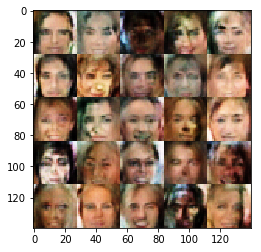

Epoch 1/3, step 1710... Discriminator Loss: 1.3200... Generator Loss: 0.7545... Total: 2.0745
Epoch 1/3, step 1720... Discriminator Loss: 1.4874... Generator Loss: 0.9101... Total: 2.3975
Epoch 1/3, step 1730... Discriminator Loss: 1.4454... Generator Loss: 0.6314... Total: 2.0768
Epoch 1/3, step 1740... Discriminator Loss: 1.4240... Generator Loss: 0.6233... Total: 2.0473
Epoch 1/3, step 1750... Discriminator Loss: 1.3395... Generator Loss: 0.8204... Total: 2.1600
Epoch 1/3, step 1760... Discriminator Loss: 1.2865... Generator Loss: 0.7298... Total: 2.0163
Epoch 1/3, step 1770... Discriminator Loss: 1.3330... Generator Loss: 0.9483... Total: 2.2813
Epoch 1/3, step 1780... Discriminator Loss: 1.4762... Generator Loss: 0.9316... Total: 2.4078
Epoch 1/3, step 1790... Discriminator Loss: 1.3175... Generator Loss: 0.8756... Total: 2.1931
Epoch 1/3, step 1800... Discriminator Loss: 1.3812... Generator Loss: 0.8453... Total: 2.2266


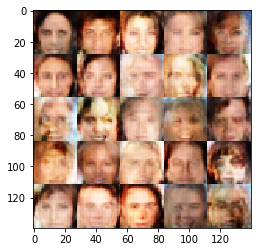

Epoch 1/3, step 1810... Discriminator Loss: 1.4255... Generator Loss: 0.8673... Total: 2.2927
Epoch 1/3, step 1820... Discriminator Loss: 1.3787... Generator Loss: 1.0729... Total: 2.4516
Epoch 1/3, step 1830... Discriminator Loss: 1.4573... Generator Loss: 1.1474... Total: 2.6048
Epoch 1/3, step 1840... Discriminator Loss: 1.3312... Generator Loss: 0.8737... Total: 2.2049
Epoch 1/3, step 1850... Discriminator Loss: 1.3311... Generator Loss: 0.7798... Total: 2.1109
Epoch 1/3, step 1860... Discriminator Loss: 1.3847... Generator Loss: 0.8151... Total: 2.1998
Epoch 1/3, step 1870... Discriminator Loss: 1.4386... Generator Loss: 0.7447... Total: 2.1833
Epoch 1/3, step 1880... Discriminator Loss: 1.3401... Generator Loss: 0.7262... Total: 2.0663
Epoch 1/3, step 1890... Discriminator Loss: 1.4022... Generator Loss: 1.0074... Total: 2.4096
Epoch 1/3, step 1900... Discriminator Loss: 1.3743... Generator Loss: 0.7079... Total: 2.0822


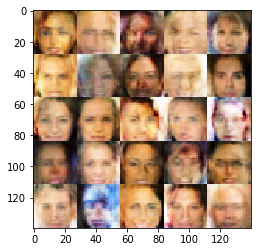

Epoch 1/3, step 1910... Discriminator Loss: 1.3915... Generator Loss: 0.9550... Total: 2.3466
Epoch 1/3, step 1920... Discriminator Loss: 1.5336... Generator Loss: 0.8594... Total: 2.3930
Epoch 1/3, step 1930... Discriminator Loss: 1.4373... Generator Loss: 0.9777... Total: 2.4150
Epoch 1/3, step 1940... Discriminator Loss: 1.3801... Generator Loss: 1.0686... Total: 2.4487
Epoch 1/3, step 1950... Discriminator Loss: 1.4928... Generator Loss: 1.0421... Total: 2.5349
Epoch 1/3, step 1960... Discriminator Loss: 1.3500... Generator Loss: 0.8672... Total: 2.2172
Epoch 1/3, step 1970... Discriminator Loss: 1.5100... Generator Loss: 0.7059... Total: 2.2159
Epoch 1/3, step 1980... Discriminator Loss: 1.5299... Generator Loss: 0.9622... Total: 2.4921
Epoch 1/3, step 1990... Discriminator Loss: 1.4679... Generator Loss: 0.8373... Total: 2.3052
Epoch 1/3, step 2000... Discriminator Loss: 1.3531... Generator Loss: 1.0152... Total: 2.3683


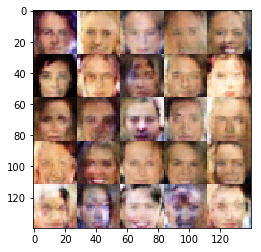

Epoch 1/3, step 2010... Discriminator Loss: 1.5031... Generator Loss: 0.7155... Total: 2.2186
Epoch 1/3, step 2020... Discriminator Loss: 1.3858... Generator Loss: 0.6470... Total: 2.0328
Epoch 1/3, step 2030... Discriminator Loss: 1.4547... Generator Loss: 0.7987... Total: 2.2534
Epoch 1/3, step 2040... Discriminator Loss: 1.4677... Generator Loss: 0.8993... Total: 2.3671
Epoch 1/3, step 2050... Discriminator Loss: 1.3198... Generator Loss: 0.9193... Total: 2.2391
Epoch 1/3, step 2060... Discriminator Loss: 1.4746... Generator Loss: 0.9024... Total: 2.3770
Epoch 1/3, step 2070... Discriminator Loss: 1.4954... Generator Loss: 0.6213... Total: 2.1167
Epoch 1/3, step 2080... Discriminator Loss: 1.4020... Generator Loss: 0.6195... Total: 2.0215
Epoch 1/3, step 2090... Discriminator Loss: 1.3081... Generator Loss: 0.8785... Total: 2.1866
Epoch 1/3, step 2100... Discriminator Loss: 1.4083... Generator Loss: 1.0992... Total: 2.5075


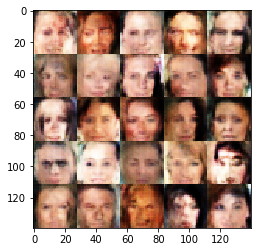

Epoch 1/3, step 2110... Discriminator Loss: 1.4689... Generator Loss: 0.6770... Total: 2.1459
Epoch 1/3, step 2120... Discriminator Loss: 1.6255... Generator Loss: 1.4067... Total: 3.0322
Epoch 1/3, step 2130... Discriminator Loss: 1.4185... Generator Loss: 0.8011... Total: 2.2196
Epoch 1/3, step 2140... Discriminator Loss: 1.5289... Generator Loss: 0.7513... Total: 2.2802
Epoch 1/3, step 2150... Discriminator Loss: 1.4709... Generator Loss: 0.7699... Total: 2.2407
Epoch 1/3, step 2160... Discriminator Loss: 1.3281... Generator Loss: 0.6842... Total: 2.0123
Epoch 1/3, step 2170... Discriminator Loss: 1.4590... Generator Loss: 0.9175... Total: 2.3765
Epoch 1/3, step 2180... Discriminator Loss: 1.3915... Generator Loss: 0.8194... Total: 2.2109
Epoch 1/3, step 2190... Discriminator Loss: 1.5340... Generator Loss: 0.7395... Total: 2.2736
Epoch 1/3, step 2200... Discriminator Loss: 1.2858... Generator Loss: 0.7582... Total: 2.0440


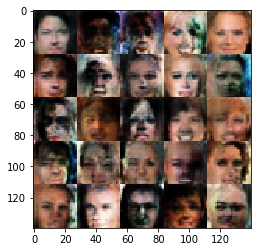

Epoch 1/3, step 2210... Discriminator Loss: 1.3743... Generator Loss: 0.8716... Total: 2.2459
Epoch 1/3, step 2220... Discriminator Loss: 2.1568... Generator Loss: 2.2463... Total: 4.4032
Epoch 1/3, step 2230... Discriminator Loss: 1.3524... Generator Loss: 0.7161... Total: 2.0686
Epoch 1/3, step 2240... Discriminator Loss: 1.4397... Generator Loss: 0.8529... Total: 2.2927
Epoch 1/3, step 2250... Discriminator Loss: 1.2811... Generator Loss: 0.7808... Total: 2.0620
Epoch 1/3, step 2260... Discriminator Loss: 1.3854... Generator Loss: 0.8113... Total: 2.1967
Epoch 1/3, step 2270... Discriminator Loss: 1.4440... Generator Loss: 0.6602... Total: 2.1043
Epoch 1/3, step 2280... Discriminator Loss: 1.3261... Generator Loss: 1.0103... Total: 2.3364
Epoch 1/3, step 2290... Discriminator Loss: 1.3622... Generator Loss: 1.1749... Total: 2.5371
Epoch 1/3, step 2300... Discriminator Loss: 1.3003... Generator Loss: 0.8817... Total: 2.1820


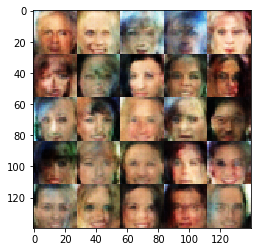

Epoch 1/3, step 2310... Discriminator Loss: 1.2787... Generator Loss: 1.1460... Total: 2.4248
Epoch 1/3, step 2320... Discriminator Loss: 1.3038... Generator Loss: 0.6776... Total: 1.9814
Epoch 1/3, step 2330... Discriminator Loss: 1.1759... Generator Loss: 0.9850... Total: 2.1609
Epoch 1/3, step 2340... Discriminator Loss: 1.4794... Generator Loss: 0.6334... Total: 2.1129
Epoch 1/3, step 2350... Discriminator Loss: 1.3177... Generator Loss: 1.0951... Total: 2.4128
Epoch 1/3, step 2360... Discriminator Loss: 1.3925... Generator Loss: 0.9966... Total: 2.3891
Epoch 1/3, step 2370... Discriminator Loss: 1.4432... Generator Loss: 1.4410... Total: 2.8842
Epoch 1/3, step 2380... Discriminator Loss: 1.4785... Generator Loss: 1.1970... Total: 2.6756
Epoch 1/3, step 2390... Discriminator Loss: 1.3849... Generator Loss: 0.9818... Total: 2.3667
Epoch 1/3, step 2400... Discriminator Loss: 1.1992... Generator Loss: 1.0637... Total: 2.2629


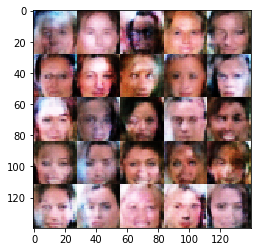

Epoch 1/3, step 2410... Discriminator Loss: 1.3664... Generator Loss: 1.1545... Total: 2.5209
Epoch 1/3, step 2420... Discriminator Loss: 1.2742... Generator Loss: 1.2873... Total: 2.5615
Epoch 1/3, step 2430... Discriminator Loss: 1.3640... Generator Loss: 0.8342... Total: 2.1982
Epoch 1/3, step 2440... Discriminator Loss: 1.4979... Generator Loss: 0.9909... Total: 2.4888
Epoch 1/3, step 2450... Discriminator Loss: 1.3772... Generator Loss: 0.6351... Total: 2.0123
Epoch 1/3, step 2460... Discriminator Loss: 1.4737... Generator Loss: 1.0016... Total: 2.4752
Epoch 1/3, step 2470... Discriminator Loss: 1.3638... Generator Loss: 1.1115... Total: 2.4753
Epoch 1/3, step 2480... Discriminator Loss: 1.4388... Generator Loss: 0.7727... Total: 2.2115
Epoch 1/3, step 2490... Discriminator Loss: 1.5038... Generator Loss: 1.0660... Total: 2.5698
Epoch 1/3, step 2500... Discriminator Loss: 1.5833... Generator Loss: 0.6721... Total: 2.2554


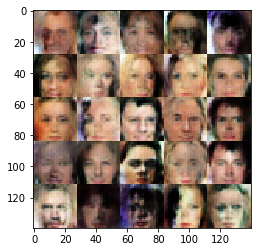

Epoch 1/3, step 2510... Discriminator Loss: 1.3230... Generator Loss: 1.0310... Total: 2.3540
Epoch 1/3, step 2520... Discriminator Loss: 1.4356... Generator Loss: 1.2754... Total: 2.7110
Epoch 1/3, step 2530... Discriminator Loss: 1.3315... Generator Loss: 0.8079... Total: 2.1394
Epoch 1/3, step 2540... Discriminator Loss: 1.4281... Generator Loss: 0.6970... Total: 2.1252
Epoch 1/3, step 2550... Discriminator Loss: 1.4115... Generator Loss: 0.7229... Total: 2.1344
Epoch 1/3, step 2560... Discriminator Loss: 1.4820... Generator Loss: 0.6603... Total: 2.1423
Epoch 1/3, step 2570... Discriminator Loss: 1.4533... Generator Loss: 0.8492... Total: 2.3026
Epoch 1/3, step 2580... Discriminator Loss: 1.4390... Generator Loss: 0.8961... Total: 2.3351
Epoch 1/3, step 2590... Discriminator Loss: 1.3713... Generator Loss: 0.7772... Total: 2.1485
Epoch 1/3, step 2600... Discriminator Loss: 1.4290... Generator Loss: 0.6947... Total: 2.1236


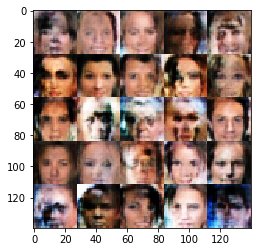

Epoch 1/3, step 2610... Discriminator Loss: 1.3849... Generator Loss: 0.9630... Total: 2.3479
Epoch 1/3, step 2620... Discriminator Loss: 1.2854... Generator Loss: 0.7847... Total: 2.0701
Epoch 1/3, step 2630... Discriminator Loss: 1.2749... Generator Loss: 0.7554... Total: 2.0303
Epoch 1/3, step 2640... Discriminator Loss: 1.2850... Generator Loss: 0.6972... Total: 1.9822
Epoch 1/3, step 2650... Discriminator Loss: 1.5050... Generator Loss: 0.4905... Total: 1.9955
Epoch 1/3, step 2660... Discriminator Loss: 1.3990... Generator Loss: 1.5741... Total: 2.9731
Epoch 1/3, step 2670... Discriminator Loss: 1.2751... Generator Loss: 0.7655... Total: 2.0406
Epoch 1/3, step 2680... Discriminator Loss: 1.6040... Generator Loss: 0.5876... Total: 2.1916
Epoch 1/3, step 2690... Discriminator Loss: 1.3242... Generator Loss: 0.9656... Total: 2.2897
Epoch 1/3, step 2700... Discriminator Loss: 1.3574... Generator Loss: 0.8207... Total: 2.1781


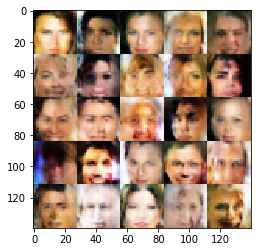

Epoch 1/3, step 2710... Discriminator Loss: 1.2923... Generator Loss: 0.8902... Total: 2.1825
Epoch 1/3, step 2720... Discriminator Loss: 1.6196... Generator Loss: 1.5827... Total: 3.2023
Epoch 1/3, step 2730... Discriminator Loss: 1.5248... Generator Loss: 0.7329... Total: 2.2577
Epoch 1/3, step 2740... Discriminator Loss: 1.3386... Generator Loss: 0.8304... Total: 2.1690
Epoch 1/3, step 2750... Discriminator Loss: 1.5477... Generator Loss: 0.6131... Total: 2.1607
Epoch 1/3, step 2760... Discriminator Loss: 1.4146... Generator Loss: 0.7268... Total: 2.1414
Epoch 1/3, step 2770... Discriminator Loss: 1.2892... Generator Loss: 0.9187... Total: 2.2079
Epoch 1/3, step 2780... Discriminator Loss: 1.4036... Generator Loss: 1.3448... Total: 2.7484
Epoch 1/3, step 2790... Discriminator Loss: 1.4534... Generator Loss: 0.8242... Total: 2.2776
Epoch 1/3, step 2800... Discriminator Loss: 1.4249... Generator Loss: 0.7776... Total: 2.2025


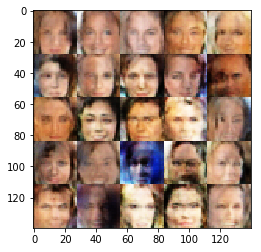

Epoch 1/3, step 2810... Discriminator Loss: 1.4190... Generator Loss: 0.5783... Total: 1.9973
Epoch 1/3, step 2820... Discriminator Loss: 1.4096... Generator Loss: 0.9859... Total: 2.3955
Epoch 1/3, step 2830... Discriminator Loss: 1.4090... Generator Loss: 1.0328... Total: 2.4418
Epoch 1/3, step 2840... Discriminator Loss: 1.3855... Generator Loss: 0.9961... Total: 2.3815
Epoch 1/3, step 2850... Discriminator Loss: 1.4169... Generator Loss: 0.7917... Total: 2.2085
Epoch 1/3, step 2860... Discriminator Loss: 1.3167... Generator Loss: 0.9692... Total: 2.2860
Epoch 1/3, step 2870... Discriminator Loss: 1.3315... Generator Loss: 0.9445... Total: 2.2760
Epoch 1/3, step 2880... Discriminator Loss: 1.3576... Generator Loss: 0.8583... Total: 2.2159
Epoch 1/3, step 2890... Discriminator Loss: 1.3432... Generator Loss: 0.9191... Total: 2.2623
Epoch 1/3, step 2900... Discriminator Loss: 1.4495... Generator Loss: 1.0296... Total: 2.4791


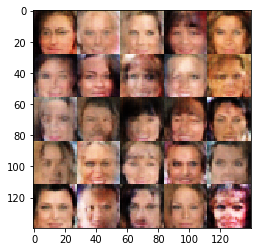

Epoch 1/3, step 2910... Discriminator Loss: 1.4033... Generator Loss: 0.8788... Total: 2.2821
Epoch 1/3, step 2920... Discriminator Loss: 1.4529... Generator Loss: 0.8640... Total: 2.3169
Epoch 1/3, step 2930... Discriminator Loss: 1.4028... Generator Loss: 0.9541... Total: 2.3569
Epoch 1/3, step 2940... Discriminator Loss: 1.4643... Generator Loss: 0.7109... Total: 2.1752
Epoch 1/3, step 2950... Discriminator Loss: 1.4716... Generator Loss: 1.0022... Total: 2.4738
Epoch 1/3, step 2960... Discriminator Loss: 1.2947... Generator Loss: 1.0262... Total: 2.3209
Epoch 1/3, step 2970... Discriminator Loss: 1.2902... Generator Loss: 0.7654... Total: 2.0556
Epoch 1/3, step 2980... Discriminator Loss: 1.3617... Generator Loss: 0.9210... Total: 2.2827
Epoch 1/3, step 2990... Discriminator Loss: 1.3930... Generator Loss: 0.9244... Total: 2.3174
Epoch 1/3, step 3000... Discriminator Loss: 1.3032... Generator Loss: 0.7732... Total: 2.0763


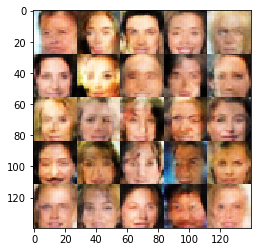

Epoch 1/3, step 3010... Discriminator Loss: 1.3512... Generator Loss: 1.0562... Total: 2.4074
Epoch 1/3, step 3020... Discriminator Loss: 1.5948... Generator Loss: 0.3995... Total: 1.9943
Epoch 1/3, step 3030... Discriminator Loss: 1.4454... Generator Loss: 1.1542... Total: 2.5996
Epoch 1/3, step 3040... Discriminator Loss: 1.4098... Generator Loss: 0.8828... Total: 2.2926
Epoch 1/3, step 3050... Discriminator Loss: 1.4271... Generator Loss: 0.7603... Total: 2.1875
Epoch 1/3, step 3060... Discriminator Loss: 1.3855... Generator Loss: 0.9587... Total: 2.3443
Epoch 1/3, step 3070... Discriminator Loss: 1.4312... Generator Loss: 1.1670... Total: 2.5982
Epoch 1/3, step 3080... Discriminator Loss: 1.3717... Generator Loss: 1.2830... Total: 2.6546
Epoch 1/3, step 3090... Discriminator Loss: 1.4441... Generator Loss: 1.0346... Total: 2.4788
Epoch 1/3, step 3100... Discriminator Loss: 1.3941... Generator Loss: 0.9753... Total: 2.3694


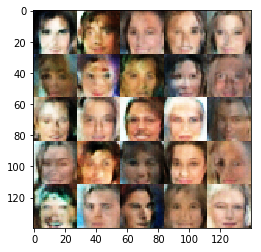

Epoch 1/3, step 3110... Discriminator Loss: 1.4221... Generator Loss: 0.7512... Total: 2.1733
Epoch 1/3, step 3120... Discriminator Loss: 1.4121... Generator Loss: 0.9347... Total: 2.3467
Epoch 1/3, step 3130... Discriminator Loss: 1.4073... Generator Loss: 1.0847... Total: 2.4920
Epoch 1/3, step 3140... Discriminator Loss: 1.4586... Generator Loss: 0.7290... Total: 2.1877
Epoch 1/3, step 3150... Discriminator Loss: 1.4221... Generator Loss: 0.8872... Total: 2.3092
Epoch 1/3, step 3160... Discriminator Loss: 1.2586... Generator Loss: 0.8546... Total: 2.1132
Epoch 2/3, step 3170... Discriminator Loss: 1.6167... Generator Loss: 0.6498... Total: 2.2665
Epoch 2/3, step 3180... Discriminator Loss: 1.3764... Generator Loss: 0.7515... Total: 2.1279
Epoch 2/3, step 3190... Discriminator Loss: 1.3252... Generator Loss: 0.6305... Total: 1.9556
Epoch 2/3, step 3200... Discriminator Loss: 1.3753... Generator Loss: 0.9697... Total: 2.3449


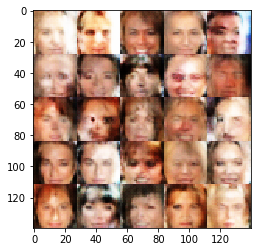

Epoch 2/3, step 3210... Discriminator Loss: 1.4210... Generator Loss: 0.8078... Total: 2.2288
Epoch 2/3, step 3220... Discriminator Loss: 1.3579... Generator Loss: 0.8378... Total: 2.1957
Epoch 2/3, step 3230... Discriminator Loss: 1.4594... Generator Loss: 0.6914... Total: 2.1507
Epoch 2/3, step 3240... Discriminator Loss: 1.4507... Generator Loss: 0.5010... Total: 1.9518
Epoch 2/3, step 3250... Discriminator Loss: 1.3978... Generator Loss: 1.0104... Total: 2.4082
Epoch 2/3, step 3260... Discriminator Loss: 1.3955... Generator Loss: 0.8143... Total: 2.2098
Epoch 2/3, step 3270... Discriminator Loss: 1.3679... Generator Loss: 1.1164... Total: 2.4843
Epoch 2/3, step 3280... Discriminator Loss: 1.4015... Generator Loss: 0.8659... Total: 2.2674
Epoch 2/3, step 3290... Discriminator Loss: 1.4257... Generator Loss: 0.9192... Total: 2.3449
Epoch 2/3, step 3300... Discriminator Loss: 1.3764... Generator Loss: 1.0005... Total: 2.3769


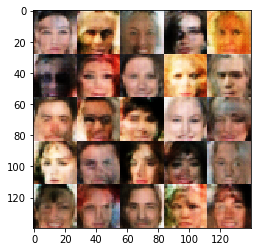

Epoch 2/3, step 3310... Discriminator Loss: 1.4444... Generator Loss: 1.0101... Total: 2.4545
Epoch 2/3, step 3320... Discriminator Loss: 1.3334... Generator Loss: 0.6471... Total: 1.9806
Epoch 2/3, step 3330... Discriminator Loss: 1.3972... Generator Loss: 0.6567... Total: 2.0539
Epoch 2/3, step 3340... Discriminator Loss: 1.4822... Generator Loss: 0.8241... Total: 2.3063
Epoch 2/3, step 3350... Discriminator Loss: 1.3648... Generator Loss: 0.7358... Total: 2.1006
Epoch 2/3, step 3360... Discriminator Loss: 1.3086... Generator Loss: 0.8117... Total: 2.1203
Epoch 2/3, step 3370... Discriminator Loss: 1.3195... Generator Loss: 1.3277... Total: 2.6472
Epoch 2/3, step 3380... Discriminator Loss: 1.4445... Generator Loss: 0.9232... Total: 2.3677
Epoch 2/3, step 3390... Discriminator Loss: 1.4027... Generator Loss: 0.7690... Total: 2.1717
Epoch 2/3, step 3400... Discriminator Loss: 1.3494... Generator Loss: 0.9058... Total: 2.2552


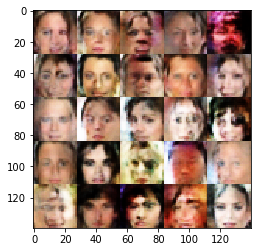

Epoch 2/3, step 3410... Discriminator Loss: 1.3308... Generator Loss: 0.8691... Total: 2.1999
Epoch 2/3, step 3420... Discriminator Loss: 1.3871... Generator Loss: 0.7607... Total: 2.1477
Epoch 2/3, step 3430... Discriminator Loss: 1.4087... Generator Loss: 0.7749... Total: 2.1836
Epoch 2/3, step 3440... Discriminator Loss: 1.4854... Generator Loss: 0.9284... Total: 2.4138
Epoch 2/3, step 3450... Discriminator Loss: 1.2926... Generator Loss: 0.9156... Total: 2.2082
Epoch 2/3, step 3460... Discriminator Loss: 1.4684... Generator Loss: 0.9345... Total: 2.4030
Epoch 2/3, step 3470... Discriminator Loss: 1.3160... Generator Loss: 0.9277... Total: 2.2437
Epoch 2/3, step 3480... Discriminator Loss: 1.4069... Generator Loss: 1.0073... Total: 2.4142
Epoch 2/3, step 3490... Discriminator Loss: 1.3024... Generator Loss: 0.7920... Total: 2.0944
Epoch 2/3, step 3500... Discriminator Loss: 1.3799... Generator Loss: 0.6407... Total: 2.0206


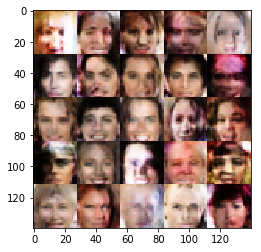

Epoch 2/3, step 3510... Discriminator Loss: 1.1909... Generator Loss: 1.0957... Total: 2.2865
Epoch 2/3, step 3520... Discriminator Loss: 1.3170... Generator Loss: 0.8980... Total: 2.2151
Epoch 2/3, step 3530... Discriminator Loss: 1.3068... Generator Loss: 0.6667... Total: 1.9735
Epoch 2/3, step 3540... Discriminator Loss: 1.3631... Generator Loss: 0.9729... Total: 2.3361
Epoch 2/3, step 3550... Discriminator Loss: 1.5156... Generator Loss: 1.0128... Total: 2.5284
Epoch 2/3, step 3560... Discriminator Loss: 1.3204... Generator Loss: 0.9783... Total: 2.2987
Epoch 2/3, step 3570... Discriminator Loss: 1.4876... Generator Loss: 0.8808... Total: 2.3684
Epoch 2/3, step 3580... Discriminator Loss: 1.4170... Generator Loss: 0.8040... Total: 2.2209
Epoch 2/3, step 3590... Discriminator Loss: 1.2610... Generator Loss: 0.8936... Total: 2.1546
Epoch 2/3, step 3600... Discriminator Loss: 1.5000... Generator Loss: 0.7389... Total: 2.2389


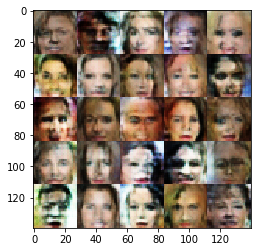

Epoch 2/3, step 3610... Discriminator Loss: 1.4567... Generator Loss: 1.0347... Total: 2.4914
Epoch 2/3, step 3620... Discriminator Loss: 1.4964... Generator Loss: 0.7043... Total: 2.2007
Epoch 2/3, step 3630... Discriminator Loss: 1.3281... Generator Loss: 0.6447... Total: 1.9728
Epoch 2/3, step 3640... Discriminator Loss: 1.3900... Generator Loss: 0.7564... Total: 2.1465
Epoch 2/3, step 3650... Discriminator Loss: 1.4640... Generator Loss: 0.8441... Total: 2.3082
Epoch 2/3, step 3660... Discriminator Loss: 1.4652... Generator Loss: 0.9851... Total: 2.4502
Epoch 2/3, step 3670... Discriminator Loss: 1.3382... Generator Loss: 0.8507... Total: 2.1889
Epoch 2/3, step 3680... Discriminator Loss: 1.4038... Generator Loss: 0.6502... Total: 2.0540
Epoch 2/3, step 3690... Discriminator Loss: 1.4001... Generator Loss: 0.9178... Total: 2.3178
Epoch 2/3, step 3700... Discriminator Loss: 1.3706... Generator Loss: 0.7878... Total: 2.1584


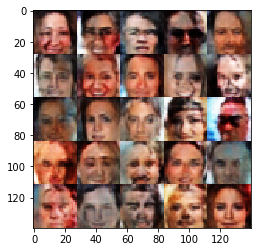

Epoch 2/3, step 3710... Discriminator Loss: 1.4927... Generator Loss: 0.6841... Total: 2.1768
Epoch 2/3, step 3720... Discriminator Loss: 1.4180... Generator Loss: 0.9691... Total: 2.3871
Epoch 2/3, step 3730... Discriminator Loss: 1.3275... Generator Loss: 0.9990... Total: 2.3265
Epoch 2/3, step 3740... Discriminator Loss: 1.4146... Generator Loss: 0.8750... Total: 2.2896
Epoch 2/3, step 3750... Discriminator Loss: 1.3369... Generator Loss: 0.9964... Total: 2.3333
Epoch 2/3, step 3760... Discriminator Loss: 1.3769... Generator Loss: 1.0413... Total: 2.4181
Epoch 2/3, step 3770... Discriminator Loss: 1.3616... Generator Loss: 0.9283... Total: 2.2899
Epoch 2/3, step 3780... Discriminator Loss: 1.3898... Generator Loss: 0.8759... Total: 2.2658
Epoch 2/3, step 3790... Discriminator Loss: 1.4215... Generator Loss: 0.7823... Total: 2.2039
Epoch 2/3, step 3800... Discriminator Loss: 1.4290... Generator Loss: 1.2181... Total: 2.6471


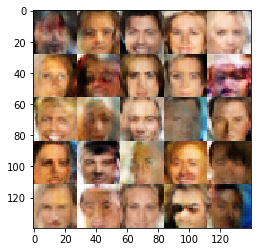

Epoch 2/3, step 3810... Discriminator Loss: 1.3720... Generator Loss: 1.2876... Total: 2.6596
Epoch 2/3, step 3820... Discriminator Loss: 1.4315... Generator Loss: 0.7813... Total: 2.2128
Epoch 2/3, step 3830... Discriminator Loss: 1.3714... Generator Loss: 0.6985... Total: 2.0699
Epoch 2/3, step 3840... Discriminator Loss: 1.3766... Generator Loss: 0.9010... Total: 2.2776
Epoch 2/3, step 3850... Discriminator Loss: 1.4080... Generator Loss: 0.6640... Total: 2.0721
Epoch 2/3, step 3860... Discriminator Loss: 1.3480... Generator Loss: 0.7998... Total: 2.1478
Epoch 2/3, step 3870... Discriminator Loss: 1.5421... Generator Loss: 0.8957... Total: 2.4378
Epoch 2/3, step 3880... Discriminator Loss: 1.2528... Generator Loss: 0.7161... Total: 1.9689
Epoch 2/3, step 3890... Discriminator Loss: 1.6050... Generator Loss: 0.5147... Total: 2.1197
Epoch 2/3, step 3900... Discriminator Loss: 1.4352... Generator Loss: 0.9282... Total: 2.3634


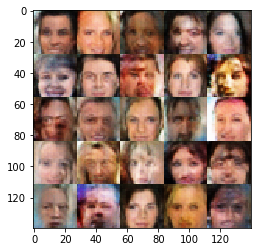

Epoch 2/3, step 3910... Discriminator Loss: 1.4502... Generator Loss: 0.8291... Total: 2.2793
Epoch 2/3, step 3920... Discriminator Loss: 1.3061... Generator Loss: 0.8109... Total: 2.1170
Epoch 2/3, step 3930... Discriminator Loss: 1.4324... Generator Loss: 0.9798... Total: 2.4121
Epoch 2/3, step 3940... Discriminator Loss: 1.3760... Generator Loss: 1.0755... Total: 2.4515
Epoch 2/3, step 3950... Discriminator Loss: 1.4139... Generator Loss: 1.0128... Total: 2.4266
Epoch 2/3, step 3960... Discriminator Loss: 1.3596... Generator Loss: 1.0155... Total: 2.3751
Epoch 2/3, step 3970... Discriminator Loss: 1.4303... Generator Loss: 1.5161... Total: 2.9464
Epoch 2/3, step 3980... Discriminator Loss: 1.3826... Generator Loss: 0.8210... Total: 2.2036
Epoch 2/3, step 3990... Discriminator Loss: 1.4022... Generator Loss: 0.7963... Total: 2.1984
Epoch 2/3, step 4000... Discriminator Loss: 1.4572... Generator Loss: 0.7967... Total: 2.2538


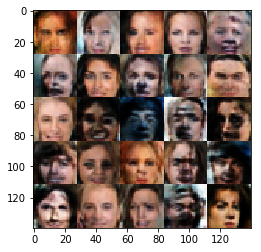

Epoch 2/3, step 4010... Discriminator Loss: 1.3492... Generator Loss: 0.8053... Total: 2.1546
Epoch 2/3, step 4020... Discriminator Loss: 1.4153... Generator Loss: 1.1385... Total: 2.5537
Epoch 2/3, step 4030... Discriminator Loss: 1.3041... Generator Loss: 0.8302... Total: 2.1343
Epoch 2/3, step 4040... Discriminator Loss: 1.3012... Generator Loss: 0.9158... Total: 2.2170
Epoch 2/3, step 4050... Discriminator Loss: 1.5133... Generator Loss: 0.5029... Total: 2.0162
Epoch 2/3, step 4060... Discriminator Loss: 1.2871... Generator Loss: 0.7340... Total: 2.0211
Epoch 2/3, step 4070... Discriminator Loss: 1.3305... Generator Loss: 0.6973... Total: 2.0279
Epoch 2/3, step 4080... Discriminator Loss: 1.2990... Generator Loss: 0.8192... Total: 2.1182
Epoch 2/3, step 4090... Discriminator Loss: 1.4397... Generator Loss: 0.8728... Total: 2.3125
Epoch 2/3, step 4100... Discriminator Loss: 1.5770... Generator Loss: 1.0118... Total: 2.5888


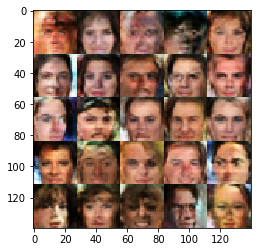

Epoch 2/3, step 4110... Discriminator Loss: 1.3692... Generator Loss: 0.8158... Total: 2.1850
Epoch 2/3, step 4120... Discriminator Loss: 1.3601... Generator Loss: 0.8395... Total: 2.1995
Epoch 2/3, step 4130... Discriminator Loss: 1.3289... Generator Loss: 0.8168... Total: 2.1457
Epoch 2/3, step 4140... Discriminator Loss: 1.3682... Generator Loss: 0.6606... Total: 2.0288
Epoch 2/3, step 4150... Discriminator Loss: 1.3003... Generator Loss: 0.8780... Total: 2.1783
Epoch 2/3, step 4160... Discriminator Loss: 1.3696... Generator Loss: 0.8292... Total: 2.1988
Epoch 2/3, step 4170... Discriminator Loss: 1.3835... Generator Loss: 0.8930... Total: 2.2765
Epoch 2/3, step 4180... Discriminator Loss: 1.4485... Generator Loss: 0.4804... Total: 1.9289
Epoch 2/3, step 4190... Discriminator Loss: 1.2883... Generator Loss: 0.7040... Total: 1.9923
Epoch 2/3, step 4200... Discriminator Loss: 1.4815... Generator Loss: 0.7339... Total: 2.2154


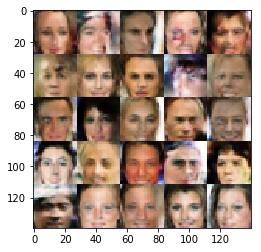

Epoch 2/3, step 4210... Discriminator Loss: 1.2997... Generator Loss: 0.6361... Total: 1.9358
Epoch 2/3, step 4220... Discriminator Loss: 1.5061... Generator Loss: 0.7471... Total: 2.2531
Epoch 2/3, step 4230... Discriminator Loss: 1.3040... Generator Loss: 0.8659... Total: 2.1699
Epoch 2/3, step 4240... Discriminator Loss: 1.4427... Generator Loss: 0.6854... Total: 2.1281
Epoch 2/3, step 4250... Discriminator Loss: 1.3721... Generator Loss: 0.8451... Total: 2.2172
Epoch 2/3, step 4260... Discriminator Loss: 1.3717... Generator Loss: 0.9347... Total: 2.3064
Epoch 2/3, step 4270... Discriminator Loss: 1.3398... Generator Loss: 1.0081... Total: 2.3479
Epoch 2/3, step 4280... Discriminator Loss: 1.3493... Generator Loss: 0.7175... Total: 2.0668
Epoch 2/3, step 4290... Discriminator Loss: 1.4301... Generator Loss: 0.7304... Total: 2.1606
Epoch 2/3, step 4300... Discriminator Loss: 1.3986... Generator Loss: 0.9743... Total: 2.3729


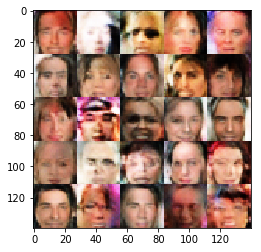

Epoch 2/3, step 4310... Discriminator Loss: 1.4004... Generator Loss: 0.6556... Total: 2.0560
Epoch 2/3, step 4320... Discriminator Loss: 1.3345... Generator Loss: 0.6219... Total: 1.9565
Epoch 2/3, step 4330... Discriminator Loss: 1.4184... Generator Loss: 0.7557... Total: 2.1741
Epoch 2/3, step 4340... Discriminator Loss: 1.4075... Generator Loss: 1.0440... Total: 2.4514
Epoch 2/3, step 4350... Discriminator Loss: 1.3768... Generator Loss: 0.7047... Total: 2.0814
Epoch 2/3, step 4360... Discriminator Loss: 1.3772... Generator Loss: 1.0536... Total: 2.4309
Epoch 2/3, step 4370... Discriminator Loss: 1.3826... Generator Loss: 0.9188... Total: 2.3014
Epoch 2/3, step 4380... Discriminator Loss: 1.4055... Generator Loss: 0.6905... Total: 2.0960
Epoch 2/3, step 4390... Discriminator Loss: 1.5180... Generator Loss: 1.2869... Total: 2.8050
Epoch 2/3, step 4400... Discriminator Loss: 1.3835... Generator Loss: 0.7039... Total: 2.0875


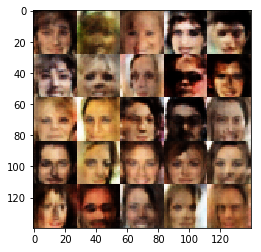

Epoch 2/3, step 4410... Discriminator Loss: 1.3104... Generator Loss: 0.7961... Total: 2.1065
Epoch 2/3, step 4420... Discriminator Loss: 1.4286... Generator Loss: 0.8582... Total: 2.2868
Epoch 2/3, step 4430... Discriminator Loss: 1.3239... Generator Loss: 0.9662... Total: 2.2901
Epoch 2/3, step 4440... Discriminator Loss: 1.4366... Generator Loss: 0.8795... Total: 2.3161
Epoch 2/3, step 4450... Discriminator Loss: 1.3743... Generator Loss: 0.8983... Total: 2.2726
Epoch 2/3, step 4460... Discriminator Loss: 1.4350... Generator Loss: 0.8256... Total: 2.2606
Epoch 2/3, step 4470... Discriminator Loss: 1.3161... Generator Loss: 0.8258... Total: 2.1419
Epoch 2/3, step 4480... Discriminator Loss: 1.3275... Generator Loss: 0.9022... Total: 2.2297
Epoch 2/3, step 4490... Discriminator Loss: 1.4061... Generator Loss: 0.7928... Total: 2.1989
Epoch 2/3, step 4500... Discriminator Loss: 1.3248... Generator Loss: 0.6536... Total: 1.9784


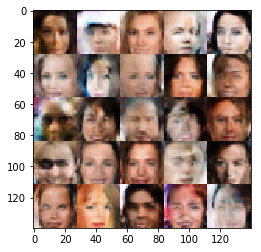

Epoch 2/3, step 4510... Discriminator Loss: 1.3580... Generator Loss: 0.9647... Total: 2.3227
Epoch 2/3, step 4520... Discriminator Loss: 1.3975... Generator Loss: 0.8709... Total: 2.2685
Epoch 2/3, step 4530... Discriminator Loss: 1.3821... Generator Loss: 0.7249... Total: 2.1070
Epoch 2/3, step 4540... Discriminator Loss: 1.3577... Generator Loss: 1.1476... Total: 2.5052
Epoch 2/3, step 4550... Discriminator Loss: 1.3540... Generator Loss: 0.8267... Total: 2.1806
Epoch 2/3, step 4560... Discriminator Loss: 1.4425... Generator Loss: 1.0173... Total: 2.4598
Epoch 2/3, step 4570... Discriminator Loss: 1.3828... Generator Loss: 0.7902... Total: 2.1729
Epoch 2/3, step 4580... Discriminator Loss: 1.2835... Generator Loss: 0.9710... Total: 2.2545
Epoch 2/3, step 4590... Discriminator Loss: 1.4639... Generator Loss: 0.8256... Total: 2.2895
Epoch 2/3, step 4600... Discriminator Loss: 1.3712... Generator Loss: 1.1239... Total: 2.4952


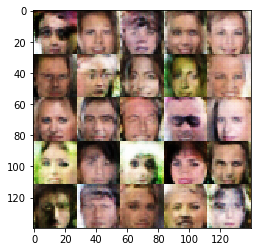

Epoch 2/3, step 4610... Discriminator Loss: 1.3130... Generator Loss: 0.6847... Total: 1.9977
Epoch 2/3, step 4620... Discriminator Loss: 1.4130... Generator Loss: 1.2063... Total: 2.6193
Epoch 2/3, step 4630... Discriminator Loss: 1.2913... Generator Loss: 0.8527... Total: 2.1439
Epoch 2/3, step 4640... Discriminator Loss: 1.3967... Generator Loss: 0.7242... Total: 2.1208
Epoch 2/3, step 4650... Discriminator Loss: 1.4141... Generator Loss: 0.9390... Total: 2.3531
Epoch 2/3, step 4660... Discriminator Loss: 1.3336... Generator Loss: 0.8021... Total: 2.1357
Epoch 2/3, step 4670... Discriminator Loss: 1.3732... Generator Loss: 0.5907... Total: 1.9640
Epoch 2/3, step 4680... Discriminator Loss: 1.3597... Generator Loss: 0.8435... Total: 2.2032
Epoch 2/3, step 4690... Discriminator Loss: 1.4307... Generator Loss: 0.6465... Total: 2.0772
Epoch 2/3, step 4700... Discriminator Loss: 1.4122... Generator Loss: 0.9045... Total: 2.3167


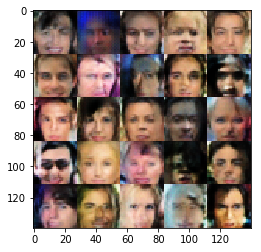

Epoch 2/3, step 4710... Discriminator Loss: 1.4046... Generator Loss: 0.7239... Total: 2.1285
Epoch 2/3, step 4720... Discriminator Loss: 1.4199... Generator Loss: 0.7801... Total: 2.2000
Epoch 2/3, step 4730... Discriminator Loss: 1.3891... Generator Loss: 0.7057... Total: 2.0949
Epoch 2/3, step 4740... Discriminator Loss: 1.2538... Generator Loss: 0.6829... Total: 1.9367
Epoch 2/3, step 4750... Discriminator Loss: 1.4495... Generator Loss: 0.8950... Total: 2.3445
Epoch 2/3, step 4760... Discriminator Loss: 1.3660... Generator Loss: 0.8603... Total: 2.2263
Epoch 2/3, step 4770... Discriminator Loss: 1.3450... Generator Loss: 1.0611... Total: 2.4062
Epoch 2/3, step 4780... Discriminator Loss: 1.3302... Generator Loss: 1.0461... Total: 2.3763
Epoch 2/3, step 4790... Discriminator Loss: 1.3898... Generator Loss: 0.7634... Total: 2.1532
Epoch 2/3, step 4800... Discriminator Loss: 1.3490... Generator Loss: 0.7355... Total: 2.0845


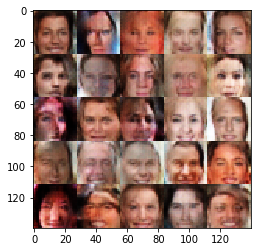

Epoch 2/3, step 4810... Discriminator Loss: 1.3880... Generator Loss: 0.9876... Total: 2.3755
Epoch 2/3, step 4820... Discriminator Loss: 1.3828... Generator Loss: 0.8562... Total: 2.2390
Epoch 2/3, step 4830... Discriminator Loss: 1.4775... Generator Loss: 0.7273... Total: 2.2049
Epoch 2/3, step 4840... Discriminator Loss: 1.3749... Generator Loss: 0.8986... Total: 2.2735
Epoch 2/3, step 4850... Discriminator Loss: 1.3201... Generator Loss: 0.8211... Total: 2.1412
Epoch 2/3, step 4860... Discriminator Loss: 1.4484... Generator Loss: 0.8462... Total: 2.2946
Epoch 2/3, step 4870... Discriminator Loss: 1.4168... Generator Loss: 0.8042... Total: 2.2210
Epoch 2/3, step 4880... Discriminator Loss: 1.3860... Generator Loss: 0.7640... Total: 2.1500
Epoch 2/3, step 4890... Discriminator Loss: 1.4797... Generator Loss: 0.6799... Total: 2.1597
Epoch 2/3, step 4900... Discriminator Loss: 1.4219... Generator Loss: 0.7355... Total: 2.1574


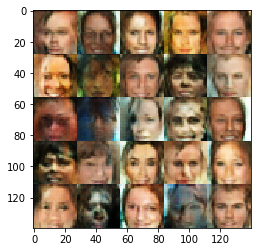

Epoch 2/3, step 4910... Discriminator Loss: 1.4373... Generator Loss: 0.6767... Total: 2.1140
Epoch 2/3, step 4920... Discriminator Loss: 1.3445... Generator Loss: 0.7941... Total: 2.1386
Epoch 2/3, step 4930... Discriminator Loss: 1.4399... Generator Loss: 0.7346... Total: 2.1745
Epoch 2/3, step 4940... Discriminator Loss: 1.3723... Generator Loss: 0.8968... Total: 2.2691
Epoch 2/3, step 4950... Discriminator Loss: 1.3389... Generator Loss: 0.9522... Total: 2.2911
Epoch 2/3, step 4960... Discriminator Loss: 1.3256... Generator Loss: 0.8206... Total: 2.1462
Epoch 2/3, step 4970... Discriminator Loss: 1.4268... Generator Loss: 1.0053... Total: 2.4320
Epoch 2/3, step 4980... Discriminator Loss: 1.3619... Generator Loss: 0.7358... Total: 2.0976
Epoch 2/3, step 4990... Discriminator Loss: 1.3304... Generator Loss: 0.8967... Total: 2.2271
Epoch 2/3, step 5000... Discriminator Loss: 1.3711... Generator Loss: 0.8626... Total: 2.2337


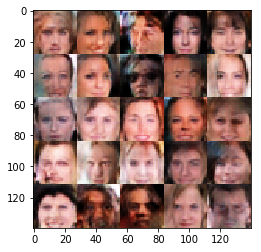

Epoch 2/3, step 5010... Discriminator Loss: 1.3962... Generator Loss: 1.0293... Total: 2.4255
Epoch 2/3, step 5020... Discriminator Loss: 1.4009... Generator Loss: 0.7705... Total: 2.1714
Epoch 2/3, step 5030... Discriminator Loss: 1.4233... Generator Loss: 0.9306... Total: 2.3539
Epoch 2/3, step 5040... Discriminator Loss: 1.4565... Generator Loss: 0.6819... Total: 2.1383
Epoch 2/3, step 5050... Discriminator Loss: 1.3959... Generator Loss: 1.0223... Total: 2.4182
Epoch 2/3, step 5060... Discriminator Loss: 1.2598... Generator Loss: 0.7348... Total: 1.9946
Epoch 2/3, step 5070... Discriminator Loss: 1.3698... Generator Loss: 0.9017... Total: 2.2715
Epoch 2/3, step 5080... Discriminator Loss: 1.3107... Generator Loss: 0.7280... Total: 2.0387
Epoch 2/3, step 5090... Discriminator Loss: 1.2400... Generator Loss: 1.2157... Total: 2.4558
Epoch 2/3, step 5100... Discriminator Loss: 1.3623... Generator Loss: 0.9144... Total: 2.2767


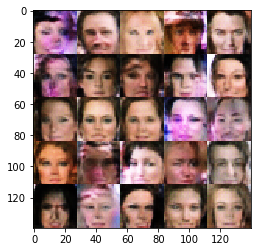

Epoch 2/3, step 5110... Discriminator Loss: 1.3787... Generator Loss: 0.8987... Total: 2.2773
Epoch 2/3, step 5120... Discriminator Loss: 1.4147... Generator Loss: 0.6505... Total: 2.0652
Epoch 2/3, step 5130... Discriminator Loss: 1.3976... Generator Loss: 0.9292... Total: 2.3268
Epoch 2/3, step 5140... Discriminator Loss: 1.4129... Generator Loss: 0.7017... Total: 2.1146
Epoch 2/3, step 5150... Discriminator Loss: 1.3873... Generator Loss: 0.7319... Total: 2.1191
Epoch 2/3, step 5160... Discriminator Loss: 1.4758... Generator Loss: 1.1982... Total: 2.6739
Epoch 2/3, step 5170... Discriminator Loss: 1.3436... Generator Loss: 0.6324... Total: 1.9760
Epoch 2/3, step 5180... Discriminator Loss: 1.4022... Generator Loss: 0.7275... Total: 2.1297
Epoch 2/3, step 5190... Discriminator Loss: 1.4601... Generator Loss: 0.7432... Total: 2.2033
Epoch 2/3, step 5200... Discriminator Loss: 1.4706... Generator Loss: 0.7425... Total: 2.2131


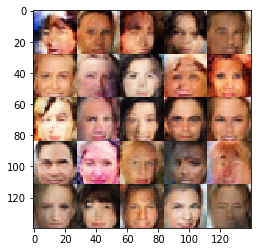

Epoch 2/3, step 5210... Discriminator Loss: 1.3462... Generator Loss: 1.0677... Total: 2.4139
Epoch 2/3, step 5220... Discriminator Loss: 1.2434... Generator Loss: 0.7570... Total: 2.0004
Epoch 2/3, step 5230... Discriminator Loss: 1.3994... Generator Loss: 0.9545... Total: 2.3538
Epoch 2/3, step 5240... Discriminator Loss: 1.2937... Generator Loss: 0.8310... Total: 2.1247
Epoch 2/3, step 5250... Discriminator Loss: 1.4408... Generator Loss: 0.8494... Total: 2.2902
Epoch 2/3, step 5260... Discriminator Loss: 1.3608... Generator Loss: 0.6950... Total: 2.0558
Epoch 2/3, step 5270... Discriminator Loss: 1.3279... Generator Loss: 0.7763... Total: 2.1042
Epoch 2/3, step 5280... Discriminator Loss: 1.4695... Generator Loss: 0.6325... Total: 2.1020
Epoch 2/3, step 5290... Discriminator Loss: 1.1827... Generator Loss: 0.8902... Total: 2.0730
Epoch 2/3, step 5300... Discriminator Loss: 1.2992... Generator Loss: 0.9837... Total: 2.2829


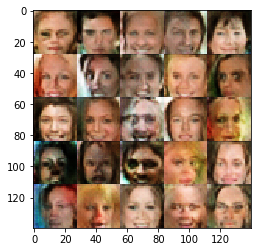

Epoch 2/3, step 5310... Discriminator Loss: 1.3888... Generator Loss: 1.0297... Total: 2.4185
Epoch 2/3, step 5320... Discriminator Loss: 1.3388... Generator Loss: 1.3183... Total: 2.6570
Epoch 2/3, step 5330... Discriminator Loss: 1.3621... Generator Loss: 0.7701... Total: 2.1322
Epoch 2/3, step 5340... Discriminator Loss: 1.3048... Generator Loss: 0.8565... Total: 2.1613
Epoch 2/3, step 5350... Discriminator Loss: 1.4851... Generator Loss: 0.9023... Total: 2.3874
Epoch 2/3, step 5360... Discriminator Loss: 1.4701... Generator Loss: 1.0550... Total: 2.5250
Epoch 2/3, step 5370... Discriminator Loss: 1.4277... Generator Loss: 0.9599... Total: 2.3877
Epoch 2/3, step 5380... Discriminator Loss: 1.2975... Generator Loss: 0.7382... Total: 2.0358
Epoch 2/3, step 5390... Discriminator Loss: 1.4125... Generator Loss: 0.8085... Total: 2.2210
Epoch 2/3, step 5400... Discriminator Loss: 1.3140... Generator Loss: 0.9603... Total: 2.2743


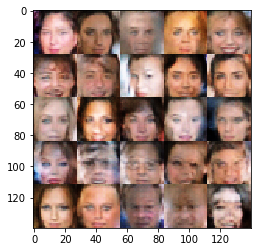

Epoch 2/3, step 5410... Discriminator Loss: 1.3224... Generator Loss: 0.8765... Total: 2.1989
Epoch 2/3, step 5420... Discriminator Loss: 1.3330... Generator Loss: 0.7876... Total: 2.1206
Epoch 2/3, step 5430... Discriminator Loss: 1.3889... Generator Loss: 1.1349... Total: 2.5238
Epoch 2/3, step 5440... Discriminator Loss: 1.3082... Generator Loss: 0.6713... Total: 1.9795
Epoch 2/3, step 5450... Discriminator Loss: 1.4090... Generator Loss: 0.9361... Total: 2.3451
Epoch 2/3, step 5460... Discriminator Loss: 1.3698... Generator Loss: 0.6630... Total: 2.0329
Epoch 2/3, step 5470... Discriminator Loss: 1.3456... Generator Loss: 0.8509... Total: 2.1965
Epoch 2/3, step 5480... Discriminator Loss: 1.4205... Generator Loss: 0.7632... Total: 2.1837
Epoch 2/3, step 5490... Discriminator Loss: 1.4895... Generator Loss: 0.6241... Total: 2.1136
Epoch 2/3, step 5500... Discriminator Loss: 1.3248... Generator Loss: 0.8391... Total: 2.1638


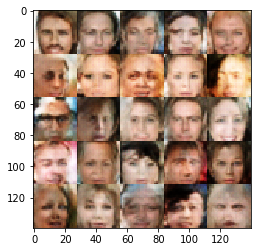

Epoch 2/3, step 5510... Discriminator Loss: 1.3588... Generator Loss: 1.2329... Total: 2.5917
Epoch 2/3, step 5520... Discriminator Loss: 1.3452... Generator Loss: 0.6945... Total: 2.0396
Epoch 2/3, step 5530... Discriminator Loss: 1.3263... Generator Loss: 0.6611... Total: 1.9874
Epoch 2/3, step 5540... Discriminator Loss: 1.3580... Generator Loss: 0.6020... Total: 1.9600
Epoch 2/3, step 5550... Discriminator Loss: 1.4236... Generator Loss: 0.8818... Total: 2.3054
Epoch 2/3, step 5560... Discriminator Loss: 1.2715... Generator Loss: 0.8146... Total: 2.0862
Epoch 2/3, step 5570... Discriminator Loss: 1.3698... Generator Loss: 0.6627... Total: 2.0325
Epoch 2/3, step 5580... Discriminator Loss: 1.3709... Generator Loss: 0.9344... Total: 2.3053
Epoch 2/3, step 5590... Discriminator Loss: 1.4116... Generator Loss: 0.9445... Total: 2.3561
Epoch 2/3, step 5600... Discriminator Loss: 1.3307... Generator Loss: 0.9568... Total: 2.2875


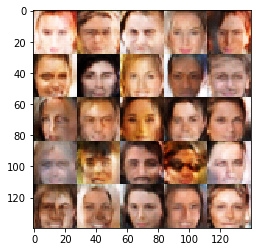

Epoch 2/3, step 5610... Discriminator Loss: 1.2842... Generator Loss: 0.8082... Total: 2.0924
Epoch 2/3, step 5620... Discriminator Loss: 1.3693... Generator Loss: 0.6438... Total: 2.0131
Epoch 2/3, step 5630... Discriminator Loss: 1.2811... Generator Loss: 0.7735... Total: 2.0545
Epoch 2/3, step 5640... Discriminator Loss: 1.3422... Generator Loss: 0.7572... Total: 2.0993
Epoch 2/3, step 5650... Discriminator Loss: 1.4729... Generator Loss: 0.8300... Total: 2.3029
Epoch 2/3, step 5660... Discriminator Loss: 1.4595... Generator Loss: 1.0177... Total: 2.4772
Epoch 2/3, step 5670... Discriminator Loss: 1.5051... Generator Loss: 0.9430... Total: 2.4481
Epoch 2/3, step 5680... Discriminator Loss: 1.4246... Generator Loss: 0.7685... Total: 2.1932
Epoch 2/3, step 5690... Discriminator Loss: 1.3771... Generator Loss: 0.9304... Total: 2.3075
Epoch 2/3, step 5700... Discriminator Loss: 1.4201... Generator Loss: 1.1094... Total: 2.5295


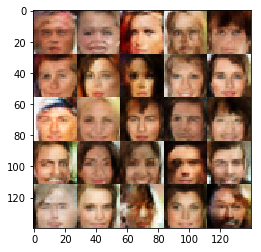

Epoch 2/3, step 5710... Discriminator Loss: 1.3826... Generator Loss: 1.0976... Total: 2.4802
Epoch 2/3, step 5720... Discriminator Loss: 1.4625... Generator Loss: 0.5834... Total: 2.0459
Epoch 2/3, step 5730... Discriminator Loss: 1.4242... Generator Loss: 0.7685... Total: 2.1927
Epoch 2/3, step 5740... Discriminator Loss: 1.2689... Generator Loss: 0.7329... Total: 2.0018
Epoch 2/3, step 5750... Discriminator Loss: 1.3802... Generator Loss: 0.6512... Total: 2.0314
Epoch 2/3, step 5760... Discriminator Loss: 1.3790... Generator Loss: 0.8257... Total: 2.2047
Epoch 2/3, step 5770... Discriminator Loss: 1.4208... Generator Loss: 0.8671... Total: 2.2879
Epoch 2/3, step 5780... Discriminator Loss: 1.3622... Generator Loss: 0.8780... Total: 2.2402
Epoch 2/3, step 5790... Discriminator Loss: 1.3615... Generator Loss: 0.8232... Total: 2.1847
Epoch 2/3, step 5800... Discriminator Loss: 1.5084... Generator Loss: 0.9749... Total: 2.4833


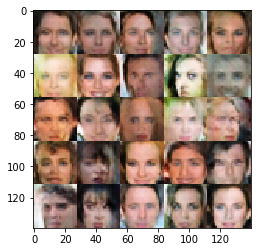

Epoch 2/3, step 5810... Discriminator Loss: 1.4188... Generator Loss: 0.8643... Total: 2.2832
Epoch 2/3, step 5820... Discriminator Loss: 1.3492... Generator Loss: 0.8766... Total: 2.2259
Epoch 2/3, step 5830... Discriminator Loss: 1.4171... Generator Loss: 0.8973... Total: 2.3144
Epoch 2/3, step 5840... Discriminator Loss: 1.4190... Generator Loss: 0.6963... Total: 2.1153
Epoch 2/3, step 5850... Discriminator Loss: 1.3778... Generator Loss: 0.8528... Total: 2.2306
Epoch 2/3, step 5860... Discriminator Loss: 1.4120... Generator Loss: 0.6697... Total: 2.0817
Epoch 2/3, step 5870... Discriminator Loss: 1.4077... Generator Loss: 0.6590... Total: 2.0666
Epoch 2/3, step 5880... Discriminator Loss: 1.3791... Generator Loss: 0.6640... Total: 2.0431
Epoch 2/3, step 5890... Discriminator Loss: 1.4286... Generator Loss: 1.1428... Total: 2.5714
Epoch 2/3, step 5900... Discriminator Loss: 1.3602... Generator Loss: 0.8340... Total: 2.1942


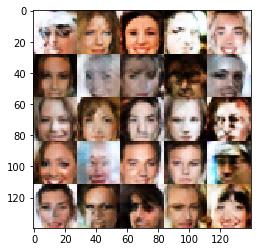

Epoch 2/3, step 5910... Discriminator Loss: 1.2818... Generator Loss: 0.7158... Total: 1.9976
Epoch 2/3, step 5920... Discriminator Loss: 1.2603... Generator Loss: 0.8495... Total: 2.1098
Epoch 2/3, step 5930... Discriminator Loss: 1.3152... Generator Loss: 0.7926... Total: 2.1078
Epoch 2/3, step 5940... Discriminator Loss: 1.3732... Generator Loss: 0.7857... Total: 2.1589
Epoch 2/3, step 5950... Discriminator Loss: 1.3107... Generator Loss: 0.9493... Total: 2.2601
Epoch 2/3, step 5960... Discriminator Loss: 1.5901... Generator Loss: 0.6940... Total: 2.2841
Epoch 2/3, step 5970... Discriminator Loss: 1.3483... Generator Loss: 1.1480... Total: 2.4963
Epoch 2/3, step 5980... Discriminator Loss: 1.3533... Generator Loss: 0.6852... Total: 2.0385
Epoch 2/3, step 5990... Discriminator Loss: 1.3841... Generator Loss: 0.8800... Total: 2.2641
Epoch 2/3, step 6000... Discriminator Loss: 1.3470... Generator Loss: 0.8175... Total: 2.1645


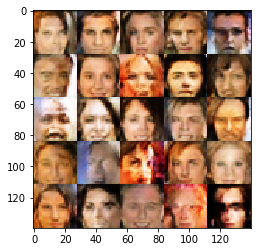

Epoch 2/3, step 6010... Discriminator Loss: 1.4738... Generator Loss: 0.8190... Total: 2.2928
Epoch 2/3, step 6020... Discriminator Loss: 1.4576... Generator Loss: 0.9953... Total: 2.4529
Epoch 2/3, step 6030... Discriminator Loss: 1.3103... Generator Loss: 0.8612... Total: 2.1715
Epoch 2/3, step 6040... Discriminator Loss: 1.5136... Generator Loss: 0.5961... Total: 2.1097
Epoch 2/3, step 6050... Discriminator Loss: 1.3301... Generator Loss: 0.7720... Total: 2.1021
Epoch 2/3, step 6060... Discriminator Loss: 1.3132... Generator Loss: 0.8929... Total: 2.2062
Epoch 2/3, step 6070... Discriminator Loss: 1.3660... Generator Loss: 0.6760... Total: 2.0420
Epoch 2/3, step 6080... Discriminator Loss: 1.4420... Generator Loss: 1.1077... Total: 2.5497
Epoch 2/3, step 6090... Discriminator Loss: 1.4173... Generator Loss: 0.7211... Total: 2.1384
Epoch 2/3, step 6100... Discriminator Loss: 1.3278... Generator Loss: 0.9066... Total: 2.2344


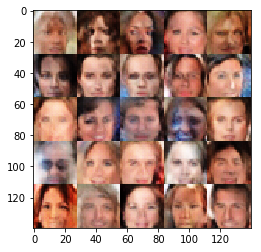

Epoch 2/3, step 6110... Discriminator Loss: 1.3434... Generator Loss: 0.6623... Total: 2.0057
Epoch 2/3, step 6120... Discriminator Loss: 1.3896... Generator Loss: 0.8248... Total: 2.2144
Epoch 2/3, step 6130... Discriminator Loss: 1.3282... Generator Loss: 0.8540... Total: 2.1822
Epoch 2/3, step 6140... Discriminator Loss: 1.3908... Generator Loss: 0.7915... Total: 2.1823
Epoch 2/3, step 6150... Discriminator Loss: 1.4846... Generator Loss: 0.8559... Total: 2.3405
Epoch 2/3, step 6160... Discriminator Loss: 1.3425... Generator Loss: 0.7889... Total: 2.1314
Epoch 2/3, step 6170... Discriminator Loss: 1.3017... Generator Loss: 0.7372... Total: 2.0389
Epoch 2/3, step 6180... Discriminator Loss: 1.4432... Generator Loss: 1.0521... Total: 2.4953
Epoch 2/3, step 6190... Discriminator Loss: 1.3752... Generator Loss: 0.7167... Total: 2.0919
Epoch 2/3, step 6200... Discriminator Loss: 1.3358... Generator Loss: 0.8101... Total: 2.1459


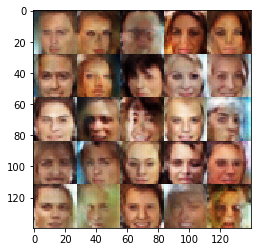

Epoch 2/3, step 6210... Discriminator Loss: 1.3925... Generator Loss: 0.9951... Total: 2.3877
Epoch 2/3, step 6220... Discriminator Loss: 1.3512... Generator Loss: 0.7300... Total: 2.0812
Epoch 2/3, step 6230... Discriminator Loss: 1.3916... Generator Loss: 0.7428... Total: 2.1344
Epoch 2/3, step 6240... Discriminator Loss: 1.4095... Generator Loss: 0.6273... Total: 2.0368
Epoch 2/3, step 6250... Discriminator Loss: 1.3754... Generator Loss: 0.7847... Total: 2.1601
Epoch 2/3, step 6260... Discriminator Loss: 1.4112... Generator Loss: 0.8735... Total: 2.2847
Epoch 2/3, step 6270... Discriminator Loss: 1.3210... Generator Loss: 0.7685... Total: 2.0895
Epoch 2/3, step 6280... Discriminator Loss: 1.3178... Generator Loss: 0.9076... Total: 2.2254
Epoch 2/3, step 6290... Discriminator Loss: 1.4465... Generator Loss: 0.8594... Total: 2.3059
Epoch 2/3, step 6300... Discriminator Loss: 1.4600... Generator Loss: 1.0543... Total: 2.5143


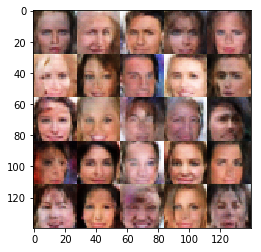

Epoch 2/3, step 6310... Discriminator Loss: 1.3582... Generator Loss: 0.6610... Total: 2.0192
Epoch 2/3, step 6320... Discriminator Loss: 1.4029... Generator Loss: 0.8021... Total: 2.2049
Epoch 2/3, step 6330... Discriminator Loss: 1.3238... Generator Loss: 0.7087... Total: 2.0325
Epoch 3/3, step 6340... Discriminator Loss: 1.3643... Generator Loss: 0.8527... Total: 2.2170
Epoch 3/3, step 6350... Discriminator Loss: 1.2712... Generator Loss: 0.8917... Total: 2.1629
Epoch 3/3, step 6360... Discriminator Loss: 1.3461... Generator Loss: 0.8490... Total: 2.1952
Epoch 3/3, step 6370... Discriminator Loss: 1.4525... Generator Loss: 0.6397... Total: 2.0922
Epoch 3/3, step 6380... Discriminator Loss: 1.3772... Generator Loss: 0.8440... Total: 2.2212
Epoch 3/3, step 6390... Discriminator Loss: 1.3653... Generator Loss: 0.8902... Total: 2.2554
Epoch 3/3, step 6400... Discriminator Loss: 1.2913... Generator Loss: 0.8748... Total: 2.1661


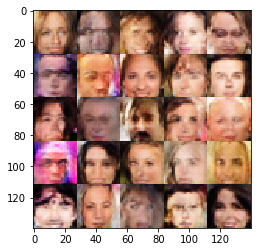

Epoch 3/3, step 6410... Discriminator Loss: 1.3386... Generator Loss: 0.8804... Total: 2.2190
Epoch 3/3, step 6420... Discriminator Loss: 1.3798... Generator Loss: 1.0832... Total: 2.4630
Epoch 3/3, step 6430... Discriminator Loss: 1.3570... Generator Loss: 0.9528... Total: 2.3099
Epoch 3/3, step 6440... Discriminator Loss: 1.4620... Generator Loss: 0.7211... Total: 2.1831
Epoch 3/3, step 6450... Discriminator Loss: 1.3209... Generator Loss: 0.7711... Total: 2.0920
Epoch 3/3, step 6460... Discriminator Loss: 1.3457... Generator Loss: 0.8386... Total: 2.1842
Epoch 3/3, step 6470... Discriminator Loss: 1.3915... Generator Loss: 0.8165... Total: 2.2080
Epoch 3/3, step 6480... Discriminator Loss: 1.3025... Generator Loss: 0.9764... Total: 2.2789
Epoch 3/3, step 6490... Discriminator Loss: 1.3403... Generator Loss: 0.9694... Total: 2.3097
Epoch 3/3, step 6500... Discriminator Loss: 1.4157... Generator Loss: 0.8235... Total: 2.2392


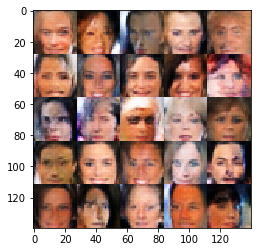

Epoch 3/3, step 6510... Discriminator Loss: 1.3404... Generator Loss: 0.7482... Total: 2.0886
Epoch 3/3, step 6520... Discriminator Loss: 1.2335... Generator Loss: 0.7151... Total: 1.9486
Epoch 3/3, step 6530... Discriminator Loss: 1.3929... Generator Loss: 0.9153... Total: 2.3081
Epoch 3/3, step 6540... Discriminator Loss: 1.3544... Generator Loss: 0.8667... Total: 2.2211
Epoch 3/3, step 6550... Discriminator Loss: 1.4108... Generator Loss: 0.7980... Total: 2.2089
Epoch 3/3, step 6560... Discriminator Loss: 1.4071... Generator Loss: 0.7197... Total: 2.1268
Epoch 3/3, step 6570... Discriminator Loss: 1.3360... Generator Loss: 0.8168... Total: 2.1528
Epoch 3/3, step 6580... Discriminator Loss: 1.3747... Generator Loss: 0.8536... Total: 2.2283
Epoch 3/3, step 6590... Discriminator Loss: 1.3043... Generator Loss: 0.6866... Total: 1.9909
Epoch 3/3, step 6600... Discriminator Loss: 1.4058... Generator Loss: 0.9390... Total: 2.3447


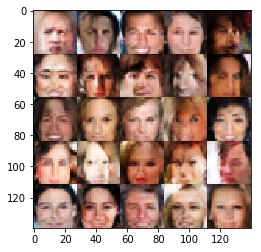

Epoch 3/3, step 6610... Discriminator Loss: 1.4415... Generator Loss: 0.8661... Total: 2.3076
Epoch 3/3, step 6620... Discriminator Loss: 1.3625... Generator Loss: 0.8970... Total: 2.2595
Epoch 3/3, step 6630... Discriminator Loss: 1.4310... Generator Loss: 1.2148... Total: 2.6458
Epoch 3/3, step 6640... Discriminator Loss: 1.3620... Generator Loss: 0.8962... Total: 2.2582
Epoch 3/3, step 6650... Discriminator Loss: 1.2595... Generator Loss: 0.8269... Total: 2.0864
Epoch 3/3, step 6660... Discriminator Loss: 1.3244... Generator Loss: 0.8586... Total: 2.1830
Epoch 3/3, step 6670... Discriminator Loss: 1.4748... Generator Loss: 0.7990... Total: 2.2738
Epoch 3/3, step 6680... Discriminator Loss: 1.3925... Generator Loss: 0.7028... Total: 2.0953
Epoch 3/3, step 6690... Discriminator Loss: 1.3759... Generator Loss: 0.7429... Total: 2.1188
Epoch 3/3, step 6700... Discriminator Loss: 1.3880... Generator Loss: 1.0713... Total: 2.4592


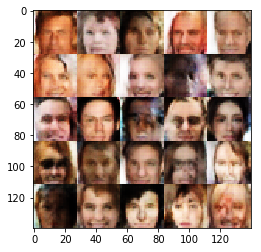

Epoch 3/3, step 6710... Discriminator Loss: 1.3454... Generator Loss: 0.9522... Total: 2.2976
Epoch 3/3, step 6720... Discriminator Loss: 1.4201... Generator Loss: 0.9866... Total: 2.4067
Epoch 3/3, step 6730... Discriminator Loss: 1.3280... Generator Loss: 0.8131... Total: 2.1411
Epoch 3/3, step 6740... Discriminator Loss: 1.3901... Generator Loss: 0.9582... Total: 2.3483
Epoch 3/3, step 6750... Discriminator Loss: 1.4677... Generator Loss: 0.7735... Total: 2.2412
Epoch 3/3, step 6760... Discriminator Loss: 1.4900... Generator Loss: 0.5498... Total: 2.0398
Epoch 3/3, step 6770... Discriminator Loss: 1.3971... Generator Loss: 0.7970... Total: 2.1941
Epoch 3/3, step 6780... Discriminator Loss: 1.2880... Generator Loss: 0.7384... Total: 2.0264
Epoch 3/3, step 6790... Discriminator Loss: 1.4086... Generator Loss: 0.6977... Total: 2.1063
Epoch 3/3, step 6800... Discriminator Loss: 1.4667... Generator Loss: 0.8957... Total: 2.3624


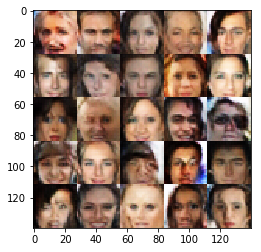

Epoch 3/3, step 6810... Discriminator Loss: 1.3861... Generator Loss: 0.7517... Total: 2.1378
Epoch 3/3, step 6820... Discriminator Loss: 1.2388... Generator Loss: 0.8093... Total: 2.0481
Epoch 3/3, step 6830... Discriminator Loss: 1.5243... Generator Loss: 0.7819... Total: 2.3062
Epoch 3/3, step 6840... Discriminator Loss: 1.3218... Generator Loss: 0.8450... Total: 2.1667
Epoch 3/3, step 6850... Discriminator Loss: 1.3651... Generator Loss: 0.9021... Total: 2.2672
Epoch 3/3, step 6860... Discriminator Loss: 1.3822... Generator Loss: 0.8946... Total: 2.2768
Epoch 3/3, step 6870... Discriminator Loss: 1.3369... Generator Loss: 0.8108... Total: 2.1477
Epoch 3/3, step 6880... Discriminator Loss: 1.3886... Generator Loss: 0.9287... Total: 2.3173
Epoch 3/3, step 6890... Discriminator Loss: 1.4080... Generator Loss: 0.8870... Total: 2.2949
Epoch 3/3, step 6900... Discriminator Loss: 1.4064... Generator Loss: 0.8118... Total: 2.2182


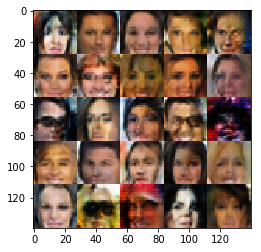

Epoch 3/3, step 6910... Discriminator Loss: 1.3539... Generator Loss: 0.7904... Total: 2.1442
Epoch 3/3, step 6920... Discriminator Loss: 1.3876... Generator Loss: 0.7719... Total: 2.1595
Epoch 3/3, step 6930... Discriminator Loss: 1.3514... Generator Loss: 1.0428... Total: 2.3942
Epoch 3/3, step 6940... Discriminator Loss: 1.5078... Generator Loss: 1.0430... Total: 2.5507
Epoch 3/3, step 6950... Discriminator Loss: 1.5098... Generator Loss: 0.6482... Total: 2.1580
Epoch 3/3, step 6960... Discriminator Loss: 1.3365... Generator Loss: 0.8881... Total: 2.2246
Epoch 3/3, step 6970... Discriminator Loss: 1.3986... Generator Loss: 0.6054... Total: 2.0040
Epoch 3/3, step 6980... Discriminator Loss: 1.3806... Generator Loss: 0.9499... Total: 2.3305
Epoch 3/3, step 6990... Discriminator Loss: 1.2881... Generator Loss: 0.6203... Total: 1.9084
Epoch 3/3, step 7000... Discriminator Loss: 1.3332... Generator Loss: 0.7250... Total: 2.0582


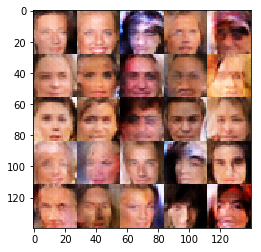

Epoch 3/3, step 7010... Discriminator Loss: 1.3948... Generator Loss: 0.9489... Total: 2.3437
Epoch 3/3, step 7020... Discriminator Loss: 1.4293... Generator Loss: 0.9133... Total: 2.3427
Epoch 3/3, step 7030... Discriminator Loss: 1.3153... Generator Loss: 0.9670... Total: 2.2823
Epoch 3/3, step 7040... Discriminator Loss: 1.3892... Generator Loss: 0.7450... Total: 2.1342
Epoch 3/3, step 7050... Discriminator Loss: 1.3974... Generator Loss: 1.0376... Total: 2.4350
Epoch 3/3, step 7060... Discriminator Loss: 1.4148... Generator Loss: 0.7961... Total: 2.2109
Epoch 3/3, step 7070... Discriminator Loss: 1.6653... Generator Loss: 0.4540... Total: 2.1193
Epoch 3/3, step 7080... Discriminator Loss: 1.4537... Generator Loss: 0.7665... Total: 2.2202
Epoch 3/3, step 7090... Discriminator Loss: 1.3713... Generator Loss: 0.8298... Total: 2.2011
Epoch 3/3, step 7100... Discriminator Loss: 1.4019... Generator Loss: 0.9947... Total: 2.3966


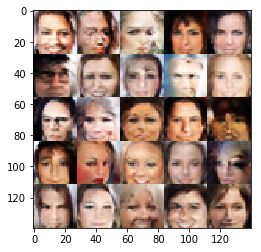

Epoch 3/3, step 7110... Discriminator Loss: 1.4799... Generator Loss: 0.6359... Total: 2.1158
Epoch 3/3, step 7120... Discriminator Loss: 1.3499... Generator Loss: 0.9540... Total: 2.3039
Epoch 3/3, step 7130... Discriminator Loss: 1.3316... Generator Loss: 1.1376... Total: 2.4692
Epoch 3/3, step 7140... Discriminator Loss: 1.3692... Generator Loss: 0.7660... Total: 2.1352
Epoch 3/3, step 7150... Discriminator Loss: 1.4076... Generator Loss: 0.8477... Total: 2.2554
Epoch 3/3, step 7160... Discriminator Loss: 1.3786... Generator Loss: 0.8170... Total: 2.1957
Epoch 3/3, step 7170... Discriminator Loss: 1.3314... Generator Loss: 0.7243... Total: 2.0557
Epoch 3/3, step 7180... Discriminator Loss: 1.4187... Generator Loss: 0.8944... Total: 2.3132
Epoch 3/3, step 7190... Discriminator Loss: 1.4236... Generator Loss: 0.7302... Total: 2.1537
Epoch 3/3, step 7200... Discriminator Loss: 1.4010... Generator Loss: 0.9705... Total: 2.3715


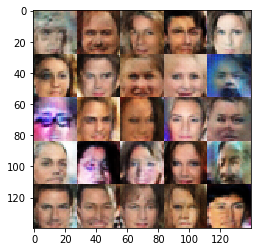

Epoch 3/3, step 7210... Discriminator Loss: 1.4859... Generator Loss: 1.0467... Total: 2.5326
Epoch 3/3, step 7220... Discriminator Loss: 1.3610... Generator Loss: 0.7643... Total: 2.1252
Epoch 3/3, step 7230... Discriminator Loss: 1.3710... Generator Loss: 0.7209... Total: 2.0919
Epoch 3/3, step 7240... Discriminator Loss: 1.4954... Generator Loss: 0.8903... Total: 2.3857
Epoch 3/3, step 7250... Discriminator Loss: 1.3581... Generator Loss: 0.8490... Total: 2.2071
Epoch 3/3, step 7260... Discriminator Loss: 1.3750... Generator Loss: 0.7748... Total: 2.1497
Epoch 3/3, step 7270... Discriminator Loss: 1.4500... Generator Loss: 0.8527... Total: 2.3027
Epoch 3/3, step 7280... Discriminator Loss: 1.3464... Generator Loss: 0.9310... Total: 2.2775
Epoch 3/3, step 7290... Discriminator Loss: 1.3983... Generator Loss: 0.8242... Total: 2.2225
Epoch 3/3, step 7300... Discriminator Loss: 1.3838... Generator Loss: 0.9088... Total: 2.2926


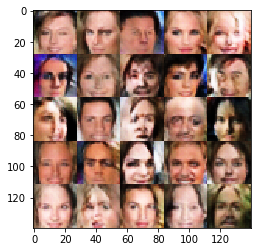

Epoch 3/3, step 7310... Discriminator Loss: 1.3630... Generator Loss: 0.7050... Total: 2.0681
Epoch 3/3, step 7320... Discriminator Loss: 1.3082... Generator Loss: 0.8230... Total: 2.1312
Epoch 3/3, step 7330... Discriminator Loss: 1.3922... Generator Loss: 0.9982... Total: 2.3904
Epoch 3/3, step 7340... Discriminator Loss: 1.3601... Generator Loss: 0.8628... Total: 2.2229
Epoch 3/3, step 7350... Discriminator Loss: 1.4403... Generator Loss: 1.0373... Total: 2.4776
Epoch 3/3, step 7360... Discriminator Loss: 1.4474... Generator Loss: 1.0161... Total: 2.4636
Epoch 3/3, step 7370... Discriminator Loss: 1.4482... Generator Loss: 0.7096... Total: 2.1579
Epoch 3/3, step 7380... Discriminator Loss: 1.4452... Generator Loss: 0.8844... Total: 2.3297
Epoch 3/3, step 7390... Discriminator Loss: 1.6104... Generator Loss: 0.5283... Total: 2.1387
Epoch 3/3, step 7400... Discriminator Loss: 1.5981... Generator Loss: 0.8473... Total: 2.4454


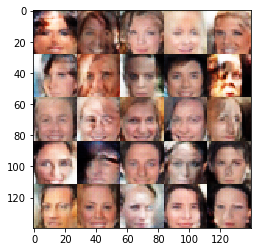

Epoch 3/3, step 7410... Discriminator Loss: 1.3169... Generator Loss: 0.8968... Total: 2.2136
Epoch 3/3, step 7420... Discriminator Loss: 1.4241... Generator Loss: 0.7731... Total: 2.1972
Epoch 3/3, step 7430... Discriminator Loss: 1.3815... Generator Loss: 0.8231... Total: 2.2046
Epoch 3/3, step 7440... Discriminator Loss: 1.3924... Generator Loss: 0.8166... Total: 2.2090
Epoch 3/3, step 7450... Discriminator Loss: 1.4717... Generator Loss: 0.6929... Total: 2.1646
Epoch 3/3, step 7460... Discriminator Loss: 1.4111... Generator Loss: 0.7838... Total: 2.1948
Epoch 3/3, step 7470... Discriminator Loss: 1.3772... Generator Loss: 0.8466... Total: 2.2238
Epoch 3/3, step 7480... Discriminator Loss: 1.3806... Generator Loss: 0.7515... Total: 2.1321
Epoch 3/3, step 7490... Discriminator Loss: 1.4103... Generator Loss: 0.8702... Total: 2.2805
Epoch 3/3, step 7500... Discriminator Loss: 1.3894... Generator Loss: 0.6398... Total: 2.0292


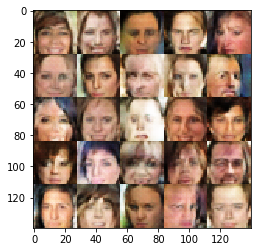

Epoch 3/3, step 7510... Discriminator Loss: 1.4369... Generator Loss: 0.7323... Total: 2.1692
Epoch 3/3, step 7520... Discriminator Loss: 1.3989... Generator Loss: 0.6356... Total: 2.0345
Epoch 3/3, step 7530... Discriminator Loss: 1.3673... Generator Loss: 0.8941... Total: 2.2614
Epoch 3/3, step 7540... Discriminator Loss: 1.4140... Generator Loss: 0.7827... Total: 2.1967
Epoch 3/3, step 7550... Discriminator Loss: 1.4224... Generator Loss: 0.7664... Total: 2.1888
Epoch 3/3, step 7560... Discriminator Loss: 1.4026... Generator Loss: 0.7101... Total: 2.1127
Epoch 3/3, step 7570... Discriminator Loss: 1.3652... Generator Loss: 0.7414... Total: 2.1066
Epoch 3/3, step 7580... Discriminator Loss: 1.4112... Generator Loss: 0.6307... Total: 2.0419
Epoch 3/3, step 7590... Discriminator Loss: 1.4617... Generator Loss: 0.9011... Total: 2.3629
Epoch 3/3, step 7600... Discriminator Loss: 1.3670... Generator Loss: 0.7789... Total: 2.1459


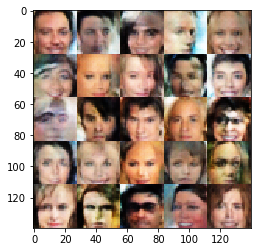

Epoch 3/3, step 7610... Discriminator Loss: 1.2749... Generator Loss: 0.7502... Total: 2.0251
Epoch 3/3, step 7620... Discriminator Loss: 1.3593... Generator Loss: 0.9867... Total: 2.3460
Epoch 3/3, step 7630... Discriminator Loss: 1.3692... Generator Loss: 0.8780... Total: 2.2472
Epoch 3/3, step 7640... Discriminator Loss: 1.3677... Generator Loss: 0.9520... Total: 2.3197
Epoch 3/3, step 7650... Discriminator Loss: 1.4213... Generator Loss: 0.6863... Total: 2.1076
Epoch 3/3, step 7660... Discriminator Loss: 1.3521... Generator Loss: 0.7660... Total: 2.1181
Epoch 3/3, step 7670... Discriminator Loss: 1.4137... Generator Loss: 1.1181... Total: 2.5319
Epoch 3/3, step 7680... Discriminator Loss: 1.3686... Generator Loss: 0.8335... Total: 2.2021
Epoch 3/3, step 7690... Discriminator Loss: 1.5245... Generator Loss: 0.8319... Total: 2.3564
Epoch 3/3, step 7700... Discriminator Loss: 1.3920... Generator Loss: 0.9708... Total: 2.3627


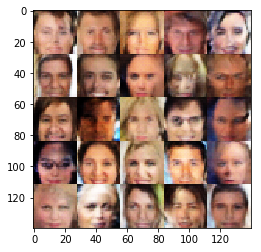

Epoch 3/3, step 7710... Discriminator Loss: 1.3942... Generator Loss: 0.9724... Total: 2.3666
Epoch 3/3, step 7720... Discriminator Loss: 1.3582... Generator Loss: 0.7624... Total: 2.1207
Epoch 3/3, step 7730... Discriminator Loss: 1.3893... Generator Loss: 0.7703... Total: 2.1597
Epoch 3/3, step 7740... Discriminator Loss: 1.5143... Generator Loss: 1.0117... Total: 2.5259
Epoch 3/3, step 7750... Discriminator Loss: 1.3360... Generator Loss: 0.9853... Total: 2.3213
Epoch 3/3, step 7760... Discriminator Loss: 1.3413... Generator Loss: 0.8441... Total: 2.1855
Epoch 3/3, step 7770... Discriminator Loss: 1.3713... Generator Loss: 0.8226... Total: 2.1940
Epoch 3/3, step 7780... Discriminator Loss: 1.3797... Generator Loss: 0.9157... Total: 2.2954
Epoch 3/3, step 7790... Discriminator Loss: 1.4281... Generator Loss: 0.6436... Total: 2.0718
Epoch 3/3, step 7800... Discriminator Loss: 1.4021... Generator Loss: 0.7213... Total: 2.1234


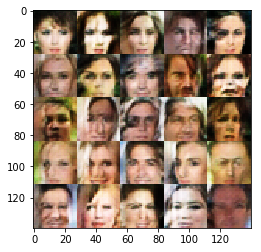

Epoch 3/3, step 7810... Discriminator Loss: 1.4710... Generator Loss: 0.9644... Total: 2.4354
Epoch 3/3, step 7820... Discriminator Loss: 1.3312... Generator Loss: 0.6866... Total: 2.0179
Epoch 3/3, step 7830... Discriminator Loss: 1.3828... Generator Loss: 0.7838... Total: 2.1665
Epoch 3/3, step 7840... Discriminator Loss: 1.4351... Generator Loss: 1.0343... Total: 2.4695
Epoch 3/3, step 7850... Discriminator Loss: 1.3595... Generator Loss: 0.8104... Total: 2.1699
Epoch 3/3, step 7860... Discriminator Loss: 1.3416... Generator Loss: 0.9441... Total: 2.2857
Epoch 3/3, step 7870... Discriminator Loss: 1.2398... Generator Loss: 0.7847... Total: 2.0245
Epoch 3/3, step 7880... Discriminator Loss: 1.3823... Generator Loss: 0.7288... Total: 2.1111
Epoch 3/3, step 7890... Discriminator Loss: 1.3657... Generator Loss: 0.8832... Total: 2.2489
Epoch 3/3, step 7900... Discriminator Loss: 1.4572... Generator Loss: 0.7797... Total: 2.2370


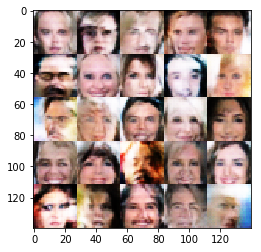

Epoch 3/3, step 7910... Discriminator Loss: 1.3899... Generator Loss: 0.9158... Total: 2.3057
Epoch 3/3, step 7920... Discriminator Loss: 1.3891... Generator Loss: 0.8474... Total: 2.2365
Epoch 3/3, step 7930... Discriminator Loss: 1.3242... Generator Loss: 0.6760... Total: 2.0003
Epoch 3/3, step 7940... Discriminator Loss: 1.4554... Generator Loss: 0.9751... Total: 2.4305
Epoch 3/3, step 7950... Discriminator Loss: 1.2042... Generator Loss: 0.8033... Total: 2.0076
Epoch 3/3, step 7960... Discriminator Loss: 1.3363... Generator Loss: 0.8513... Total: 2.1876
Epoch 3/3, step 7970... Discriminator Loss: 1.3687... Generator Loss: 0.8879... Total: 2.2566
Epoch 3/3, step 7980... Discriminator Loss: 1.3731... Generator Loss: 0.8385... Total: 2.2117
Epoch 3/3, step 7990... Discriminator Loss: 1.4240... Generator Loss: 0.8643... Total: 2.2882
Epoch 3/3, step 8000... Discriminator Loss: 1.2884... Generator Loss: 0.8630... Total: 2.1514


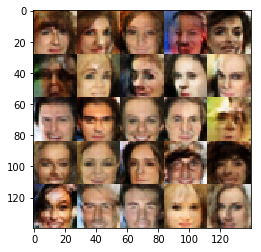

Epoch 3/3, step 8010... Discriminator Loss: 1.3737... Generator Loss: 0.9217... Total: 2.2954
Epoch 3/3, step 8020... Discriminator Loss: 1.3329... Generator Loss: 0.9294... Total: 2.2623
Epoch 3/3, step 8030... Discriminator Loss: 1.4493... Generator Loss: 0.7710... Total: 2.2203
Epoch 3/3, step 8040... Discriminator Loss: 1.3706... Generator Loss: 0.9709... Total: 2.3415
Epoch 3/3, step 8050... Discriminator Loss: 1.3811... Generator Loss: 0.8877... Total: 2.2688
Epoch 3/3, step 8060... Discriminator Loss: 1.4899... Generator Loss: 0.9022... Total: 2.3922
Epoch 3/3, step 8070... Discriminator Loss: 1.4203... Generator Loss: 0.7807... Total: 2.2010
Epoch 3/3, step 8080... Discriminator Loss: 1.4181... Generator Loss: 0.7342... Total: 2.1523
Epoch 3/3, step 8090... Discriminator Loss: 1.3694... Generator Loss: 0.7564... Total: 2.1258
Epoch 3/3, step 8100... Discriminator Loss: 1.3805... Generator Loss: 0.8299... Total: 2.2104


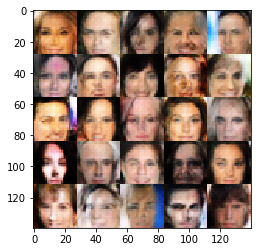

Epoch 3/3, step 8110... Discriminator Loss: 1.3525... Generator Loss: 0.7687... Total: 2.1212
Epoch 3/3, step 8120... Discriminator Loss: 1.2960... Generator Loss: 0.6661... Total: 1.9621
Epoch 3/3, step 8130... Discriminator Loss: 1.3841... Generator Loss: 0.7767... Total: 2.1608
Epoch 3/3, step 8140... Discriminator Loss: 1.4281... Generator Loss: 0.8835... Total: 2.3116
Epoch 3/3, step 8150... Discriminator Loss: 1.4310... Generator Loss: 0.9447... Total: 2.3757
Epoch 3/3, step 8160... Discriminator Loss: 1.3577... Generator Loss: 0.8452... Total: 2.2029
Epoch 3/3, step 8170... Discriminator Loss: 1.4231... Generator Loss: 0.7433... Total: 2.1664
Epoch 3/3, step 8180... Discriminator Loss: 1.4161... Generator Loss: 0.6701... Total: 2.0863
Epoch 3/3, step 8190... Discriminator Loss: 1.3863... Generator Loss: 0.8286... Total: 2.2148
Epoch 3/3, step 8200... Discriminator Loss: 1.3659... Generator Loss: 0.7780... Total: 2.1439


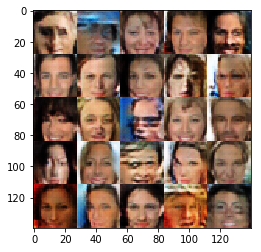

Epoch 3/3, step 8210... Discriminator Loss: 1.1599... Generator Loss: 0.7301... Total: 1.8900
Epoch 3/3, step 8220... Discriminator Loss: 1.4429... Generator Loss: 1.1209... Total: 2.5637
Epoch 3/3, step 8230... Discriminator Loss: 1.3723... Generator Loss: 0.8013... Total: 2.1736
Epoch 3/3, step 8240... Discriminator Loss: 1.3984... Generator Loss: 0.8432... Total: 2.2416
Epoch 3/3, step 8250... Discriminator Loss: 1.3459... Generator Loss: 0.7840... Total: 2.1300
Epoch 3/3, step 8260... Discriminator Loss: 1.3984... Generator Loss: 0.9536... Total: 2.3521
Epoch 3/3, step 8270... Discriminator Loss: 1.3867... Generator Loss: 0.7991... Total: 2.1857
Epoch 3/3, step 8280... Discriminator Loss: 1.5669... Generator Loss: 0.6571... Total: 2.2240
Epoch 3/3, step 8290... Discriminator Loss: 1.3839... Generator Loss: 0.8614... Total: 2.2453
Epoch 3/3, step 8300... Discriminator Loss: 1.3722... Generator Loss: 0.7149... Total: 2.0872


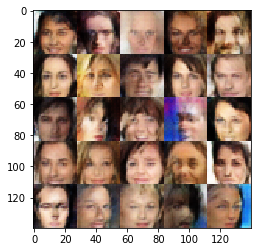

Epoch 3/3, step 8310... Discriminator Loss: 1.4224... Generator Loss: 0.8764... Total: 2.2988
Epoch 3/3, step 8320... Discriminator Loss: 1.3734... Generator Loss: 0.7820... Total: 2.1554
Epoch 3/3, step 8330... Discriminator Loss: 1.3243... Generator Loss: 0.8229... Total: 2.1471
Epoch 3/3, step 8340... Discriminator Loss: 1.4370... Generator Loss: 0.7122... Total: 2.1492
Epoch 3/3, step 8350... Discriminator Loss: 1.3571... Generator Loss: 0.8333... Total: 2.1904
Epoch 3/3, step 8360... Discriminator Loss: 1.3830... Generator Loss: 0.8880... Total: 2.2710
Epoch 3/3, step 8370... Discriminator Loss: 1.3638... Generator Loss: 0.8008... Total: 2.1646
Epoch 3/3, step 8380... Discriminator Loss: 1.3712... Generator Loss: 0.8173... Total: 2.1884
Epoch 3/3, step 8390... Discriminator Loss: 1.4406... Generator Loss: 0.7494... Total: 2.1900
Epoch 3/3, step 8400... Discriminator Loss: 1.3860... Generator Loss: 0.8057... Total: 2.1918


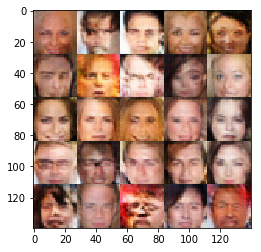

Epoch 3/3, step 8410... Discriminator Loss: 1.5066... Generator Loss: 0.8377... Total: 2.3443
Epoch 3/3, step 8420... Discriminator Loss: 1.3790... Generator Loss: 0.7028... Total: 2.0817
Epoch 3/3, step 8430... Discriminator Loss: 1.4434... Generator Loss: 0.7993... Total: 2.2427
Epoch 3/3, step 8440... Discriminator Loss: 1.3325... Generator Loss: 0.8464... Total: 2.1788
Epoch 3/3, step 8450... Discriminator Loss: 1.4920... Generator Loss: 0.8098... Total: 2.3019
Epoch 3/3, step 8460... Discriminator Loss: 1.4347... Generator Loss: 0.7267... Total: 2.1614
Epoch 3/3, step 8470... Discriminator Loss: 1.4108... Generator Loss: 0.8071... Total: 2.2179
Epoch 3/3, step 8480... Discriminator Loss: 1.2230... Generator Loss: 0.8344... Total: 2.0573
Epoch 3/3, step 8490... Discriminator Loss: 1.3467... Generator Loss: 0.7499... Total: 2.0965
Epoch 3/3, step 8500... Discriminator Loss: 1.4460... Generator Loss: 0.8281... Total: 2.2740


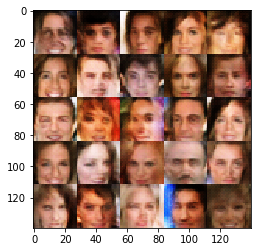

Epoch 3/3, step 8510... Discriminator Loss: 1.4148... Generator Loss: 0.7464... Total: 2.1612
Epoch 3/3, step 8520... Discriminator Loss: 1.4435... Generator Loss: 0.9363... Total: 2.3798
Epoch 3/3, step 8530... Discriminator Loss: 1.3903... Generator Loss: 0.8463... Total: 2.2366
Epoch 3/3, step 8540... Discriminator Loss: 1.3164... Generator Loss: 0.6933... Total: 2.0096
Epoch 3/3, step 8550... Discriminator Loss: 1.4280... Generator Loss: 0.7606... Total: 2.1886
Epoch 3/3, step 8560... Discriminator Loss: 1.4011... Generator Loss: 0.8593... Total: 2.2604
Epoch 3/3, step 8570... Discriminator Loss: 1.4309... Generator Loss: 0.8879... Total: 2.3189
Epoch 3/3, step 8580... Discriminator Loss: 1.3626... Generator Loss: 0.7761... Total: 2.1387
Epoch 3/3, step 8590... Discriminator Loss: 1.4407... Generator Loss: 0.9133... Total: 2.3540
Epoch 3/3, step 8600... Discriminator Loss: 1.4314... Generator Loss: 0.7404... Total: 2.1718


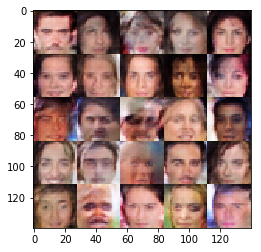

Epoch 3/3, step 8610... Discriminator Loss: 1.4075... Generator Loss: 0.9570... Total: 2.3645
Epoch 3/3, step 8620... Discriminator Loss: 1.3878... Generator Loss: 0.7984... Total: 2.1862
Epoch 3/3, step 8630... Discriminator Loss: 1.3163... Generator Loss: 0.7846... Total: 2.1009
Epoch 3/3, step 8640... Discriminator Loss: 1.4115... Generator Loss: 0.9091... Total: 2.3206
Epoch 3/3, step 8650... Discriminator Loss: 1.4011... Generator Loss: 0.9352... Total: 2.3364
Epoch 3/3, step 8660... Discriminator Loss: 1.3741... Generator Loss: 0.6984... Total: 2.0725
Epoch 3/3, step 8670... Discriminator Loss: 1.3991... Generator Loss: 0.9247... Total: 2.3239
Epoch 3/3, step 8680... Discriminator Loss: 1.3800... Generator Loss: 0.7620... Total: 2.1420
Epoch 3/3, step 8690... Discriminator Loss: 1.4193... Generator Loss: 0.7907... Total: 2.2100
Epoch 3/3, step 8700... Discriminator Loss: 1.4583... Generator Loss: 1.1322... Total: 2.5905


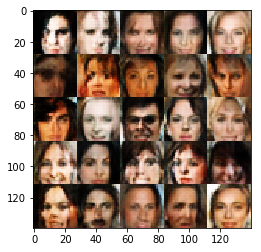

Epoch 3/3, step 8710... Discriminator Loss: 1.3787... Generator Loss: 0.8482... Total: 2.2269
Epoch 3/3, step 8720... Discriminator Loss: 1.3640... Generator Loss: 0.8679... Total: 2.2320
Epoch 3/3, step 8730... Discriminator Loss: 1.3386... Generator Loss: 0.8565... Total: 2.1950
Epoch 3/3, step 8740... Discriminator Loss: 1.3920... Generator Loss: 0.8535... Total: 2.2454
Epoch 3/3, step 8750... Discriminator Loss: 1.5160... Generator Loss: 0.6192... Total: 2.1352
Epoch 3/3, step 8760... Discriminator Loss: 1.3942... Generator Loss: 0.9007... Total: 2.2949
Epoch 3/3, step 8770... Discriminator Loss: 1.4186... Generator Loss: 0.7565... Total: 2.1751
Epoch 3/3, step 8780... Discriminator Loss: 1.2894... Generator Loss: 0.9511... Total: 2.2405
Epoch 3/3, step 8790... Discriminator Loss: 1.3848... Generator Loss: 1.0896... Total: 2.4745
Epoch 3/3, step 8800... Discriminator Loss: 1.3681... Generator Loss: 0.9022... Total: 2.2702


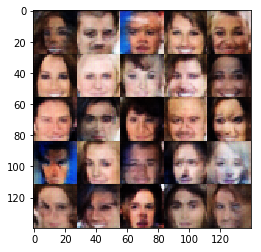

Epoch 3/3, step 8810... Discriminator Loss: 1.3343... Generator Loss: 0.9303... Total: 2.2646
Epoch 3/3, step 8820... Discriminator Loss: 1.4309... Generator Loss: 0.7810... Total: 2.2119
Epoch 3/3, step 8830... Discriminator Loss: 1.6080... Generator Loss: 0.8203... Total: 2.4283
Epoch 3/3, step 8840... Discriminator Loss: 1.2762... Generator Loss: 0.8796... Total: 2.1558
Epoch 3/3, step 8850... Discriminator Loss: 1.5278... Generator Loss: 0.6414... Total: 2.1692
Epoch 3/3, step 8860... Discriminator Loss: 1.3861... Generator Loss: 0.8252... Total: 2.2113
Epoch 3/3, step 8870... Discriminator Loss: 1.4214... Generator Loss: 0.6131... Total: 2.0346
Epoch 3/3, step 8880... Discriminator Loss: 1.6036... Generator Loss: 0.5591... Total: 2.1627
Epoch 3/3, step 8890... Discriminator Loss: 1.4451... Generator Loss: 0.7284... Total: 2.1735
Epoch 3/3, step 8900... Discriminator Loss: 1.4257... Generator Loss: 0.8001... Total: 2.2258


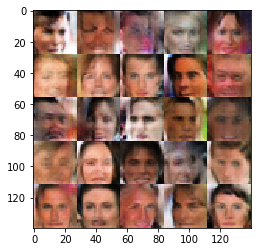

Epoch 3/3, step 8910... Discriminator Loss: 1.4277... Generator Loss: 0.7429... Total: 2.1706
Epoch 3/3, step 8920... Discriminator Loss: 1.3980... Generator Loss: 0.9045... Total: 2.3024
Epoch 3/3, step 8930... Discriminator Loss: 1.3984... Generator Loss: 0.8285... Total: 2.2269
Epoch 3/3, step 8940... Discriminator Loss: 1.3617... Generator Loss: 0.7374... Total: 2.0991
Epoch 3/3, step 8950... Discriminator Loss: 1.3981... Generator Loss: 0.7517... Total: 2.1498
Epoch 3/3, step 8960... Discriminator Loss: 1.3423... Generator Loss: 0.7684... Total: 2.1107
Epoch 3/3, step 8970... Discriminator Loss: 1.3329... Generator Loss: 0.8293... Total: 2.1622
Epoch 3/3, step 8980... Discriminator Loss: 1.4365... Generator Loss: 0.8601... Total: 2.2966
Epoch 3/3, step 8990... Discriminator Loss: 1.4172... Generator Loss: 0.8358... Total: 2.2530
Epoch 3/3, step 9000... Discriminator Loss: 1.3863... Generator Loss: 0.7681... Total: 2.1544


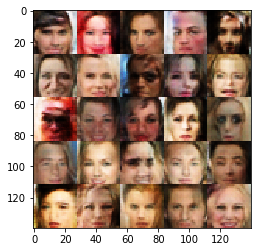

Epoch 3/3, step 9010... Discriminator Loss: 1.3166... Generator Loss: 0.7380... Total: 2.0546
Epoch 3/3, step 9020... Discriminator Loss: 1.3768... Generator Loss: 0.8297... Total: 2.2066
Epoch 3/3, step 9030... Discriminator Loss: 1.6719... Generator Loss: 0.4921... Total: 2.1640
Epoch 3/3, step 9040... Discriminator Loss: 1.4170... Generator Loss: 0.8387... Total: 2.2557
Epoch 3/3, step 9050... Discriminator Loss: 1.3500... Generator Loss: 0.8914... Total: 2.2413
Epoch 3/3, step 9060... Discriminator Loss: 1.4978... Generator Loss: 0.8099... Total: 2.3077
Epoch 3/3, step 9070... Discriminator Loss: 1.3367... Generator Loss: 0.8065... Total: 2.1432
Epoch 3/3, step 9080... Discriminator Loss: 1.4505... Generator Loss: 0.7719... Total: 2.2224
Epoch 3/3, step 9090... Discriminator Loss: 1.4020... Generator Loss: 0.9891... Total: 2.3911
Epoch 3/3, step 9100... Discriminator Loss: 1.3910... Generator Loss: 0.8610... Total: 2.2519


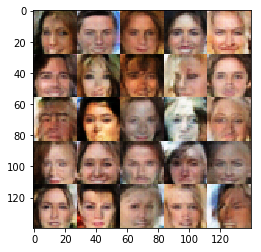

Epoch 3/3, step 9110... Discriminator Loss: 1.3895... Generator Loss: 0.8536... Total: 2.2430
Epoch 3/3, step 9120... Discriminator Loss: 1.4435... Generator Loss: 0.6565... Total: 2.1000
Epoch 3/3, step 9130... Discriminator Loss: 1.4454... Generator Loss: 0.8008... Total: 2.2462
Epoch 3/3, step 9140... Discriminator Loss: 1.3901... Generator Loss: 0.6633... Total: 2.0533
Epoch 3/3, step 9150... Discriminator Loss: 1.1699... Generator Loss: 0.8588... Total: 2.0287
Epoch 3/3, step 9160... Discriminator Loss: 1.4071... Generator Loss: 0.8482... Total: 2.2553
Epoch 3/3, step 9170... Discriminator Loss: 1.4648... Generator Loss: 0.6031... Total: 2.0679
Epoch 3/3, step 9180... Discriminator Loss: 1.3300... Generator Loss: 0.9131... Total: 2.2431
Epoch 3/3, step 9190... Discriminator Loss: 1.3730... Generator Loss: 0.8048... Total: 2.1778
Epoch 3/3, step 9200... Discriminator Loss: 1.3651... Generator Loss: 0.7500... Total: 2.1150


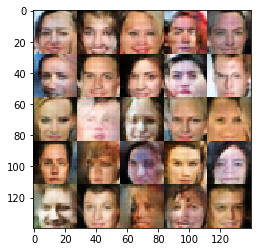

Epoch 3/3, step 9210... Discriminator Loss: 1.3625... Generator Loss: 0.9464... Total: 2.3089
Epoch 3/3, step 9220... Discriminator Loss: 1.3622... Generator Loss: 0.8355... Total: 2.1977
Epoch 3/3, step 9230... Discriminator Loss: 1.3193... Generator Loss: 0.7193... Total: 2.0386
Epoch 3/3, step 9240... Discriminator Loss: 1.4068... Generator Loss: 0.9403... Total: 2.3470
Epoch 3/3, step 9250... Discriminator Loss: 1.3713... Generator Loss: 0.9878... Total: 2.3591
Epoch 3/3, step 9260... Discriminator Loss: 1.3538... Generator Loss: 0.7596... Total: 2.1134
Epoch 3/3, step 9270... Discriminator Loss: 1.3435... Generator Loss: 0.7908... Total: 2.1343
Epoch 3/3, step 9280... Discriminator Loss: 1.4267... Generator Loss: 0.9090... Total: 2.3357
Epoch 3/3, step 9290... Discriminator Loss: 1.4056... Generator Loss: 0.7287... Total: 2.1342
Epoch 3/3, step 9300... Discriminator Loss: 1.3995... Generator Loss: 0.8266... Total: 2.2261


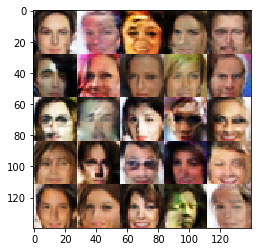

Epoch 3/3, step 9310... Discriminator Loss: 1.3335... Generator Loss: 0.6903... Total: 2.0238
Epoch 3/3, step 9320... Discriminator Loss: 1.4076... Generator Loss: 0.9220... Total: 2.3296
Epoch 3/3, step 9330... Discriminator Loss: 1.4291... Generator Loss: 0.8989... Total: 2.3280
Epoch 3/3, step 9340... Discriminator Loss: 1.4049... Generator Loss: 0.8700... Total: 2.2749
Epoch 3/3, step 9350... Discriminator Loss: 1.5045... Generator Loss: 0.8518... Total: 2.3563
Epoch 3/3, step 9360... Discriminator Loss: 1.4271... Generator Loss: 0.8520... Total: 2.2791
Epoch 3/3, step 9370... Discriminator Loss: 1.3105... Generator Loss: 0.8040... Total: 2.1146
Epoch 3/3, step 9380... Discriminator Loss: 1.4160... Generator Loss: 0.7997... Total: 2.2157
Epoch 3/3, step 9390... Discriminator Loss: 1.3631... Generator Loss: 0.8458... Total: 2.2089
Epoch 3/3, step 9400... Discriminator Loss: 1.3649... Generator Loss: 0.7826... Total: 2.1476


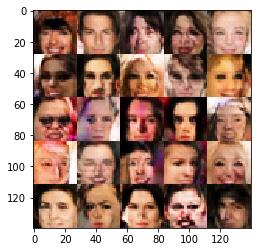

Epoch 3/3, step 9410... Discriminator Loss: 1.3608... Generator Loss: 0.9099... Total: 2.2708
Epoch 3/3, step 9420... Discriminator Loss: 1.5097... Generator Loss: 1.0266... Total: 2.5363
Epoch 3/3, step 9430... Discriminator Loss: 1.3475... Generator Loss: 0.7191... Total: 2.0667
Epoch 3/3, step 9440... Discriminator Loss: 1.3841... Generator Loss: 0.8600... Total: 2.2442
Epoch 3/3, step 9450... Discriminator Loss: 1.4013... Generator Loss: 0.9451... Total: 2.3464
Epoch 3/3, step 9460... Discriminator Loss: 1.3942... Generator Loss: 1.1585... Total: 2.5527
Epoch 3/3, step 9470... Discriminator Loss: 1.4773... Generator Loss: 0.9193... Total: 2.3965
Epoch 3/3, step 9480... Discriminator Loss: 1.4083... Generator Loss: 0.9244... Total: 2.3327
Epoch 3/3, step 9490... Discriminator Loss: 1.5141... Generator Loss: 0.8611... Total: 2.3753


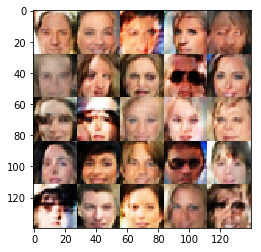

In [385]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

### Post Scriptum

I really regret not properly screenshotting the following image. This was when I used deconv instead of upsampling:

![ghost](./ghost.jpg)